# Load Dataset

In [1]:
import os
import json
import numpy as np
import tensorflow as tf
from PIL import Image
import psutil
import tracemalloc
import re
from math import sqrt
import matplotlib.pyplot as plt

In [2]:
import psutil
import matplotlib.pyplot as plt

process = psutil.Process()
ram_usage_list = []
ram_baseline = process.memory_info().rss / (1024 * 1024)
print("Baseline RAM usage (MB):", ram_baseline)


Baseline RAM usage (MB): 735.30859375


In [3]:
# Load Dataset
from google.colab import drive
drive.mount('/content/drive')

ei_export_dir = "/content/drive/MyDrive/Colab Notebooks/HAEEAI/project/uwb2-export"
labels_file = os.path.join(ei_export_dir, "info.labels")
images_dir = ei_export_dir
tracemalloc.start()
with open(labels_file, 'r') as f:
    ei_data = json.load(f)

original_width = 310
original_height = 308
new_width = 96
new_height = 96

test_annotations = {}

for entry in ei_data.get('files', []):
    rel_path = entry['path']
    boxes = []
    for bb in entry.get('boundingBoxes', []):
        x = bb['x'] * new_width / original_width
        y = bb['y'] * new_height / original_height
        w = bb['width'] * new_width / original_width
        h = bb['height'] * new_height / original_height
        boxes.append((x, y, w, h))

    if rel_path.startswith("testing/"):
        test_annotations[rel_path] = boxes



Mounted at /content/drive


# Usefull fonctions

In [4]:
def extract_polar_from_filename(filename):
    m = re.search(r'beam_(\d+)cm_([\-0-9\.]+)deg', filename)
    if not m:
        return None
    dist_cm   = float(m.group(1))
    angle_deg = float(m.group(2))
    return dist_cm, angle_deg

In [5]:
from scipy.ndimage import label, center_of_mass

def get_largest_blob_centroid(binary_mask, image_shape, grid_shape):
    """Return the centroid (pixel) of the largest blob in the heatmap"""
    labeled, num_features = label(binary_mask)
    if num_features == 0:
        return None  # No object

    # Find the largest blob
    sizes = [(labeled == i).sum() for i in range(1, num_features + 1)]
    largest_label = 1 + sizes.index(max(sizes))

    # Calculate the centroid of the largest blob
    blob_mask = (labeled == largest_label)
    cy, cx = center_of_mass(blob_mask)

    # Convert
    H_img, W_img = image_shape
    H_grid, W_grid = grid_shape
    px = (cx + 0.5) * (W_img / W_grid)
    py = (cy + 0.5) * (H_img / H_grid)

    return (px, py)

In [6]:
def pixel_to_polar(x, y, image_shape):
    H, W = image_shape
    angle_deg = (x / W) * 180.0 - 90.0
    dist_cm = (1 - y / H) * 500.0
    return dist_cm, angle_deg


In [7]:
valid_angles = [22.5, 45.0, 67.5]
valid_distances = [150, 250, 350]

def assign_to_nearest(value, valid_values):
    return min(valid_values, key=lambda x: abs(x - value))


In [8]:
def extract_polar_from_filename(filename):
    m = re.search(r'beam_(\d+)cm_([\-0-9\.]+)deg', filename)
    if not m:
        return None
    dist_cm   = float(m.group(1))
    angle_deg = float(m.group(2))
    return dist_cm, angle_deg

# Inference

TFLite model size: 24.05 KB
  GT bbox: (57, 28, 27, 24)
  GT center pixel: (71.4, 41.0)
  Pred center px: (70.0, 40.0)
Distance prediction: 250 cm, Angle prediction: 45.0 deg


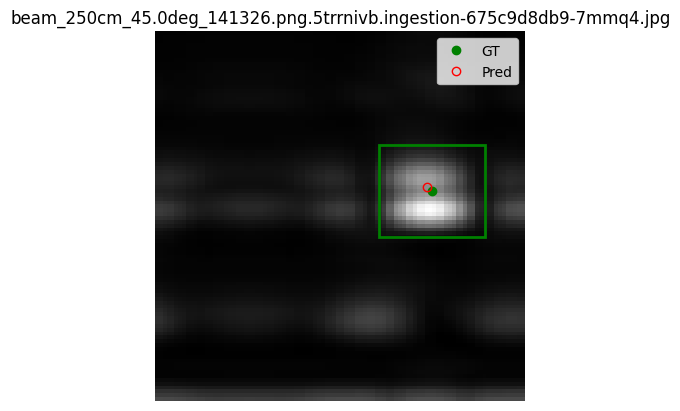

  GT bbox: (57, 28, 26, 23)
  GT center pixel: (71.2, 40.2)
  Pred center px: (70.0, 40.0)
Distance prediction: 250 cm, Angle prediction: 45.0 deg


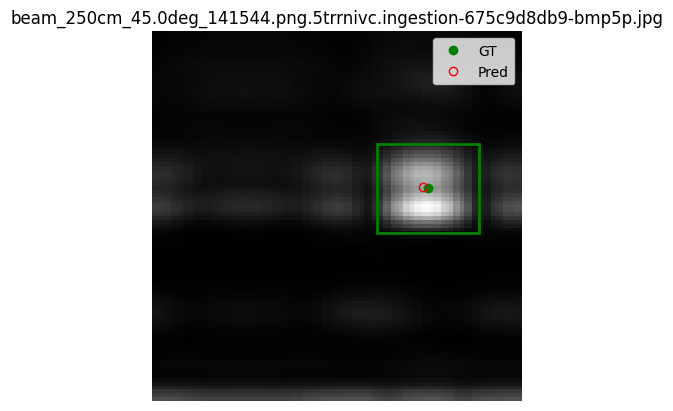

  GT bbox: (57, 28, 26, 23)
  GT center pixel: (71.2, 40.5)
  Pred center px: (70.0, 40.0)
Distance prediction: 250 cm, Angle prediction: 45.0 deg


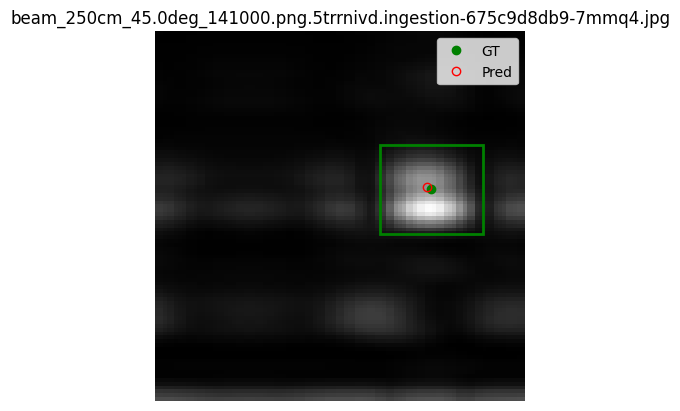

  GT bbox: (73, 28, 22, 22)
  GT center pixel: (84.9, 40.1)
  Pred center px: (84.7, 39.3)
Distance prediction: 250 cm, Angle prediction: 67.5 deg


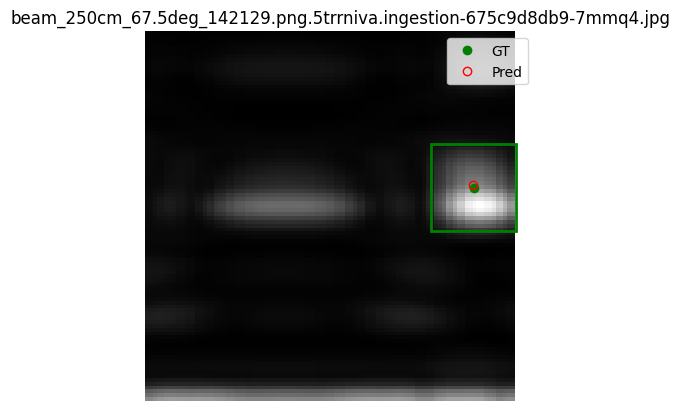

  GT bbox: (38, 27, 31, 26)
  GT center pixel: (54.3, 40.5)
  Pred center px: (55.3, 40.7)
Distance prediction: 250 cm, Angle prediction: 22.5 deg


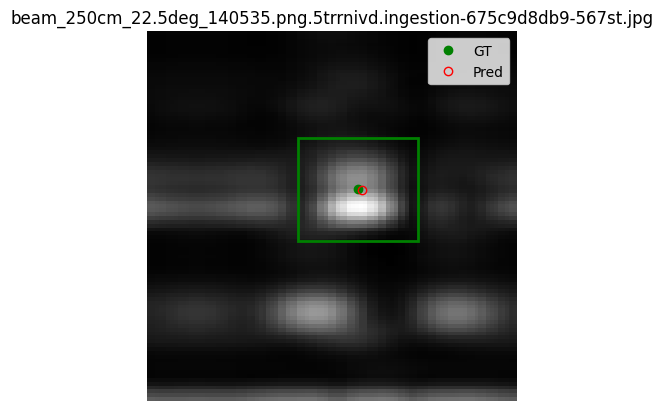

  GT bbox: (38, 27, 31, 26)
  GT center pixel: (54.3, 40.5)
  Pred center px: (55.3, 40.7)
Distance prediction: 250 cm, Angle prediction: 22.5 deg


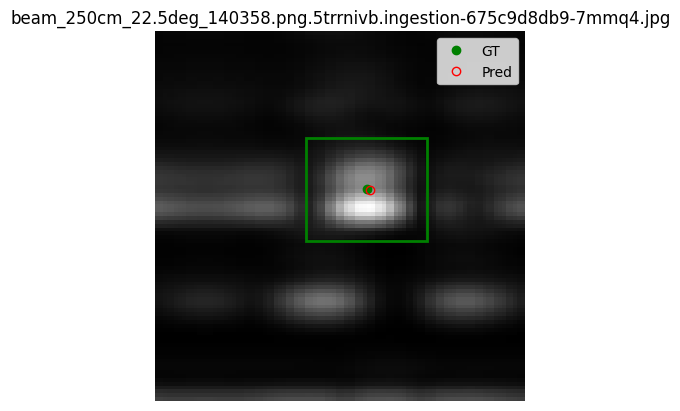

  GT bbox: (54, 27, 31, 27)
  GT center pixel: (70.5, 41.1)
  Pred center px: (70.0, 40.0)
Distance prediction: 250 cm, Angle prediction: 45.0 deg


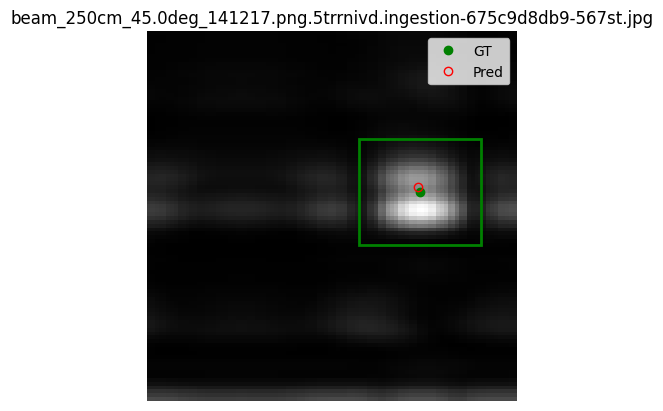

  GT bbox: (69, 27, 26, 28)
  GT center pixel: (82.8, 41.1)
  Pred center px: (86.0, 40.0)
Distance prediction: 250 cm, Angle prediction: 67.5 deg


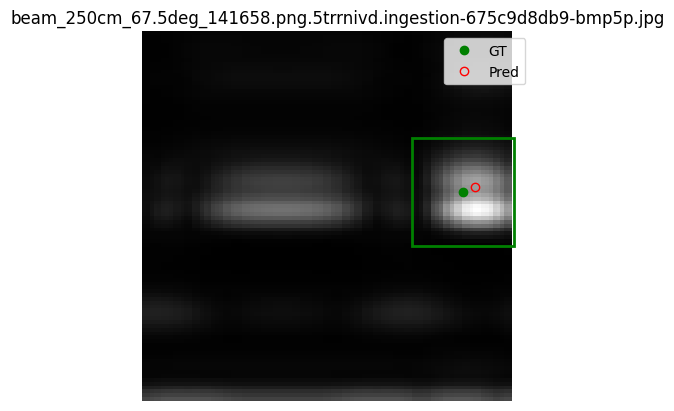

  GT bbox: (69, 27, 25, 27)
  GT center pixel: (82.7, 40.7)
  Pred center px: (86.0, 40.0)
Distance prediction: 250 cm, Angle prediction: 67.5 deg


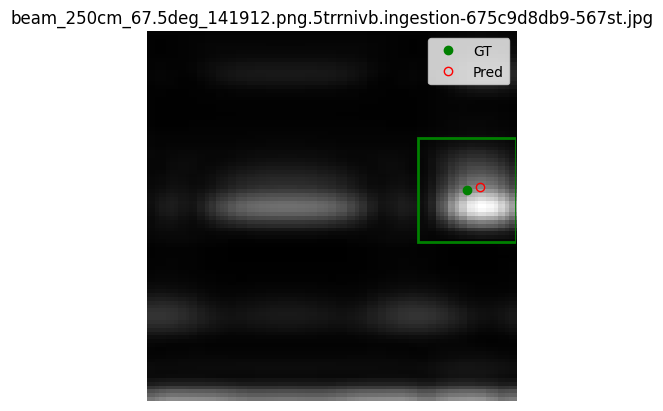

  GT bbox: (69, 9, 25, 27)
  GT center pixel: (82.7, 22.6)
  Pred center px: (84.7, 23.3)
Distance prediction: 350 cm, Angle prediction: 67.5 deg


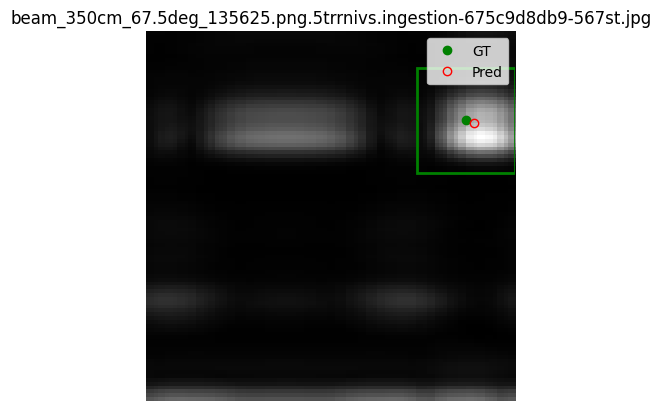

  GT bbox: (56, 26, 27, 29)
  GT center pixel: (70.0, 41.1)
  Pred center px: (70.0, 40.0)
Distance prediction: 250 cm, Angle prediction: 45.0 deg


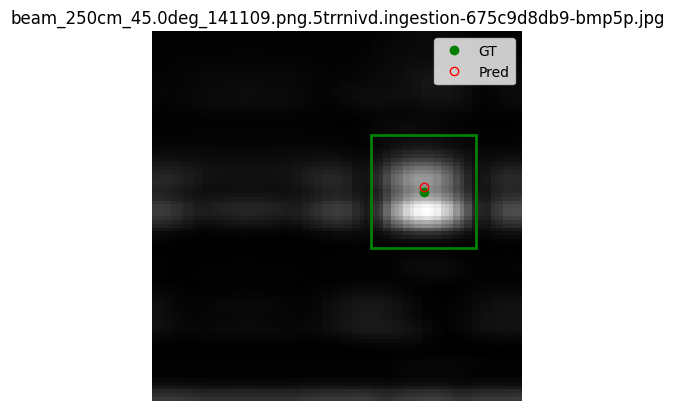

  GT bbox: (39, 24, 28, 31)
  GT center pixel: (54.0, 39.6)
  Pred center px: (52.7, 39.3)
Distance prediction: 250 cm, Angle prediction: 22.5 deg


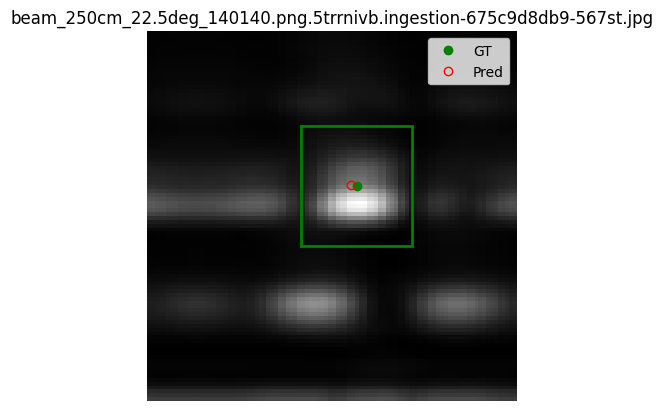

  GT bbox: (70, 25, 25, 30)
  GT center pixel: (83.5, 40.8)
  Pred center px: (86.0, 40.0)
Distance prediction: 250 cm, Angle prediction: 67.5 deg


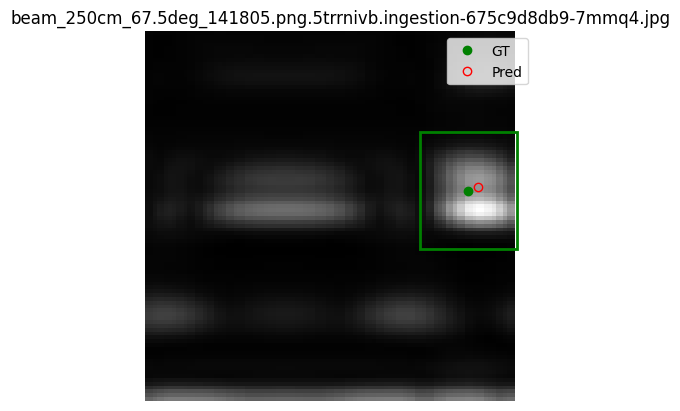

  GT bbox: (55, 25, 25, 30)
  GT center pixel: (68.0, 40.5)
  Pred center px: (70.0, 40.0)
Distance prediction: 250 cm, Angle prediction: 45.0 deg


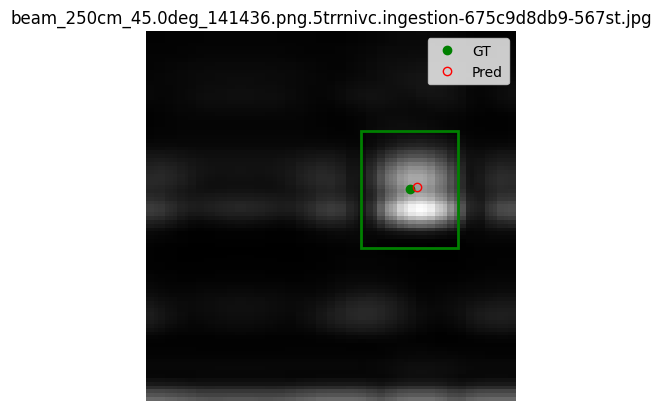

  GT bbox: (39, 23, 25, 31)
  GT center pixel: (52.2, 39.0)
  Pred center px: (52.7, 39.3)
Distance prediction: 250 cm, Angle prediction: 22.5 deg


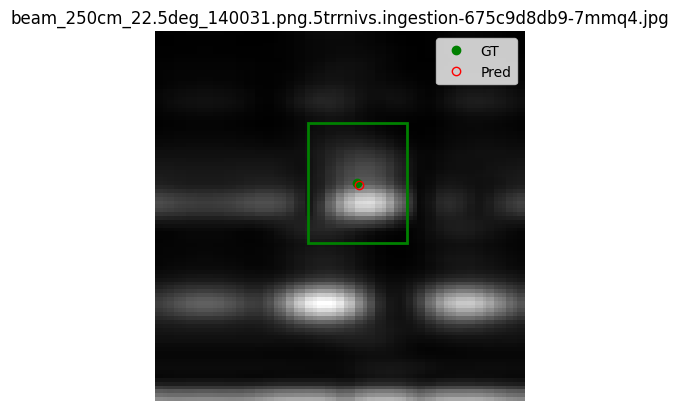

  GT bbox: (69, 5, 26, 31)
  GT center pixel: (82.5, 21.8)
  Pred center px: (84.7, 23.3)
Distance prediction: 350 cm, Angle prediction: 67.5 deg


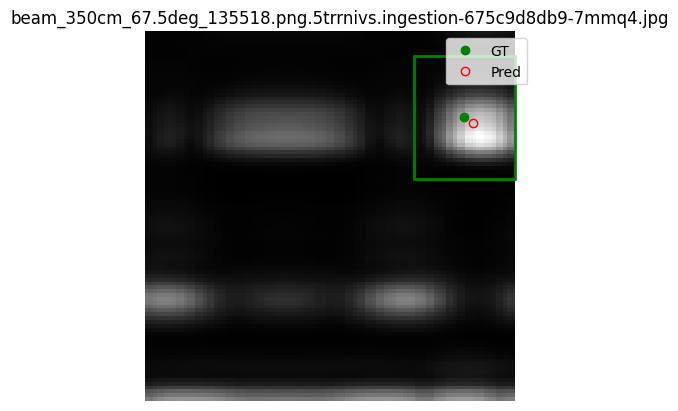

  GT bbox: (69, 4, 26, 33)
  GT center pixel: (82.5, 21.5)
  Pred center px: (84.7, 23.3)
Distance prediction: 350 cm, Angle prediction: 67.5 deg


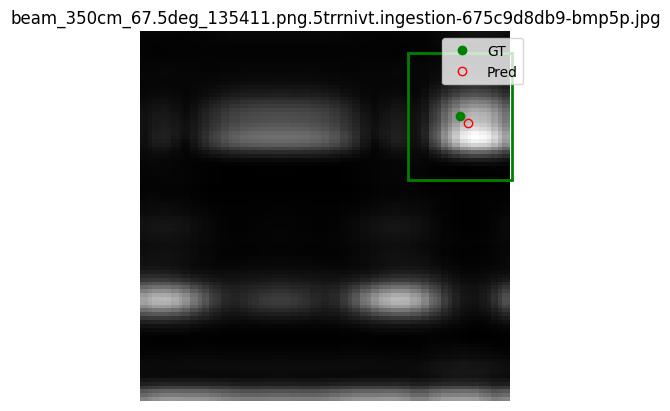

  GT bbox: (69, 4, 26, 33)
  GT center pixel: (82.5, 21.5)
  Pred center px: (84.7, 23.3)
Distance prediction: 350 cm, Angle prediction: 67.5 deg


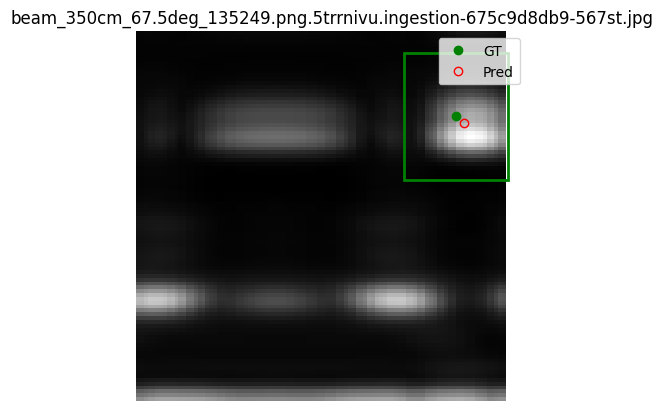

  GT bbox: (69, 23, 26, 33)
  GT center pixel: (82.5, 39.6)
  Pred center px: (86.0, 42.0)
Distance prediction: 250 cm, Angle prediction: 67.5 deg


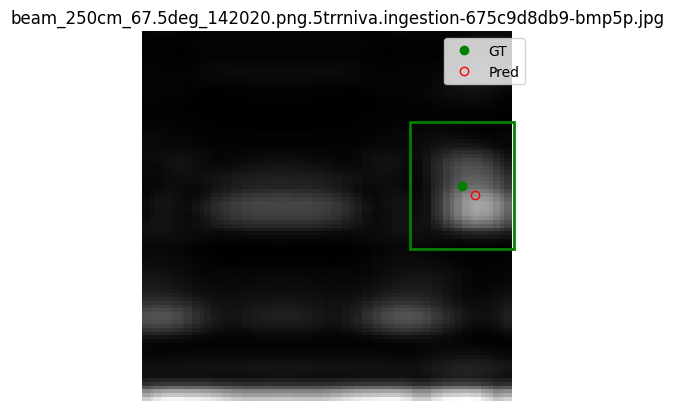

  GT bbox: (41, 22, 25, 31)
  GT center pixel: (54.5, 38.3)
  Pred center px: (55.3, 40.7)
Distance prediction: 250 cm, Angle prediction: 22.5 deg


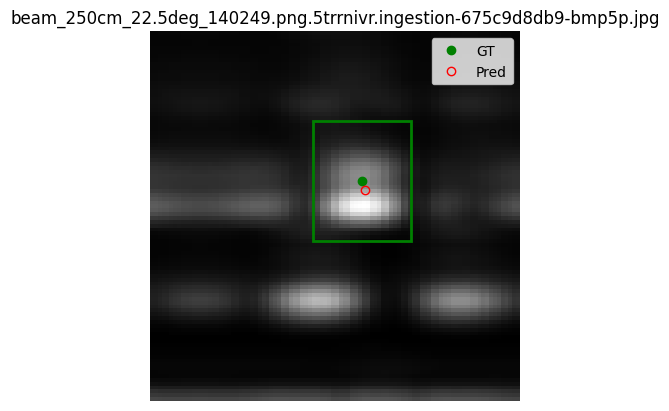

  GT bbox: (71, 3, 24, 32)
  GT center pixel: (83.9, 19.9)
  Pred center px: (84.7, 23.3)
Distance prediction: 350 cm, Angle prediction: 67.5 deg


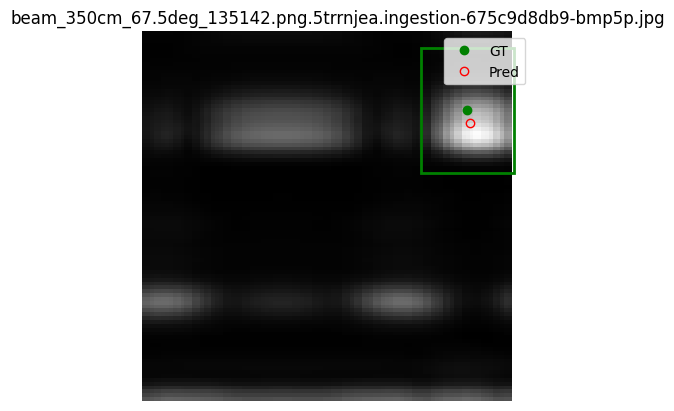

  GT bbox: (56, 3, 27, 32)
  GT center pixel: (70.5, 19.8)
  Pred center px: (70.0, 22.0)
Distance prediction: 350 cm, Angle prediction: 45.0 deg


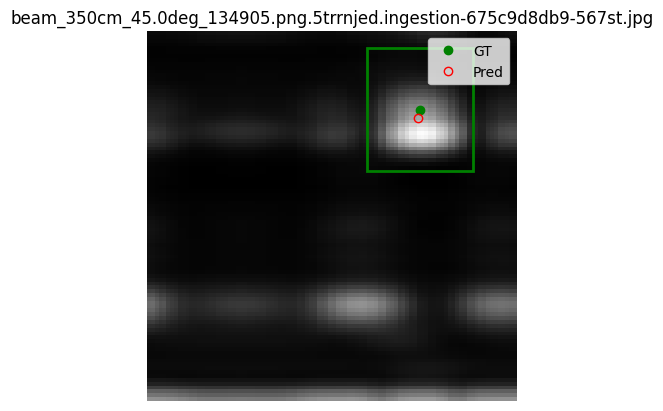

  GT bbox: (41, 2, 27, 32)
  GT center pixel: (55.0, 18.2)
  Pred center px: (54.0, 18.0)
Distance prediction: 350 cm, Angle prediction: 22.5 deg


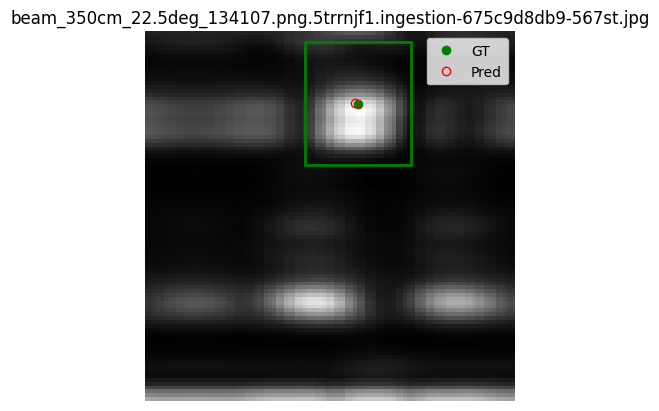

  GT bbox: (56, 2, 28, 32)
  GT center pixel: (70.1, 18.9)
  Pred center px: (68.0, 22.0)
Distance prediction: 350 cm, Angle prediction: 45.0 deg


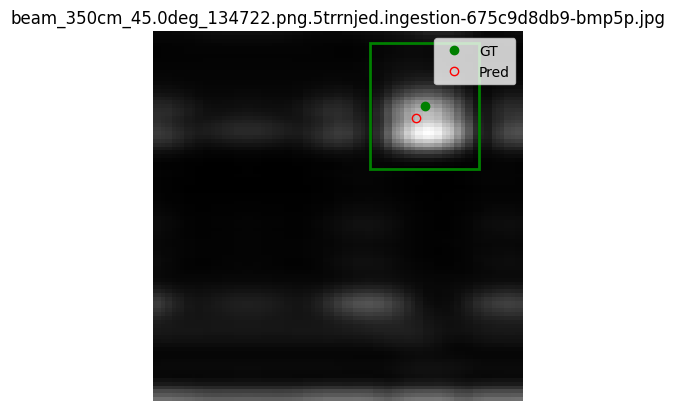

  GT bbox: (56, 2, 28, 32)
  GT center pixel: (70.1, 18.9)
  Pred center px: (70.0, 24.0)
Distance prediction: 350 cm, Angle prediction: 45.0 deg


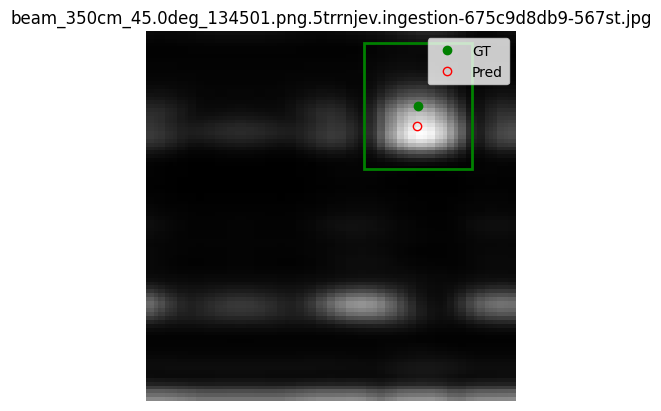

  GT bbox: (40, 1, 27, 31)
  GT center pixel: (53.9, 17.6)
  Pred center px: (40.7, 64.7)
Distance prediction: 150 cm, Angle prediction: 22.5 deg


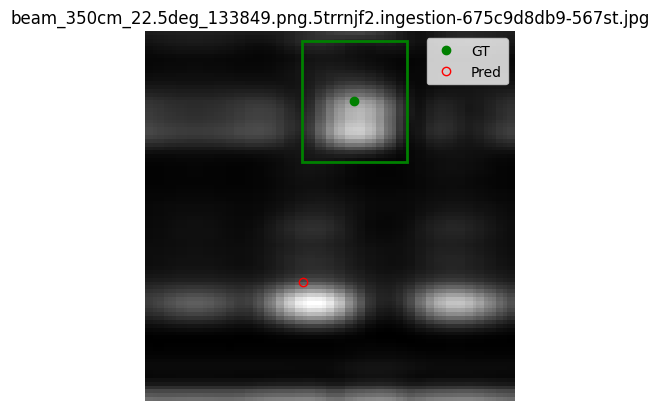

  GT bbox: (56, 48, 26, 24)
  GT center pixel: (70.3, 61.2)
  Pred center px: (68.7, 59.3)
Distance prediction: 150 cm, Angle prediction: 45.0 deg


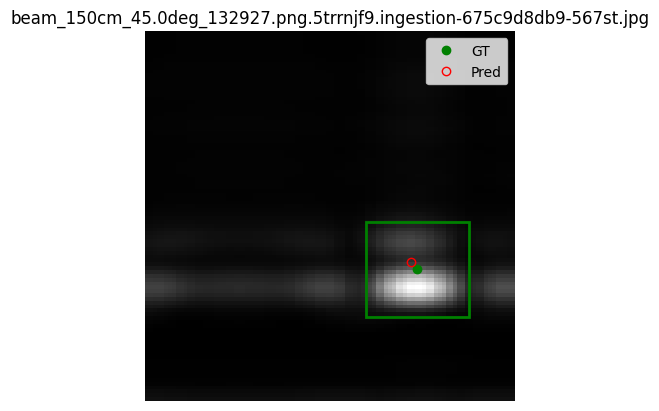

  GT bbox: (56, 9, 27, 25)
  GT center pixel: (70.8, 22.8)
  Pred center px: (70.0, 22.0)
Distance prediction: 350 cm, Angle prediction: 45.0 deg


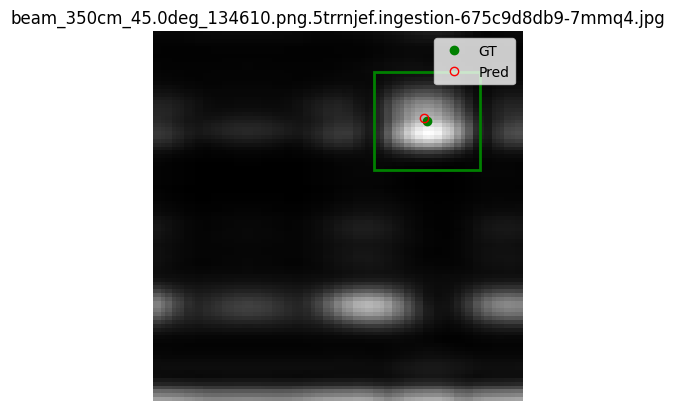

  GT bbox: (56, 48, 27, 24)
  GT center pixel: (70.5, 60.9)
  Pred center px: (68.7, 59.3)
Distance prediction: 150 cm, Angle prediction: 45.0 deg


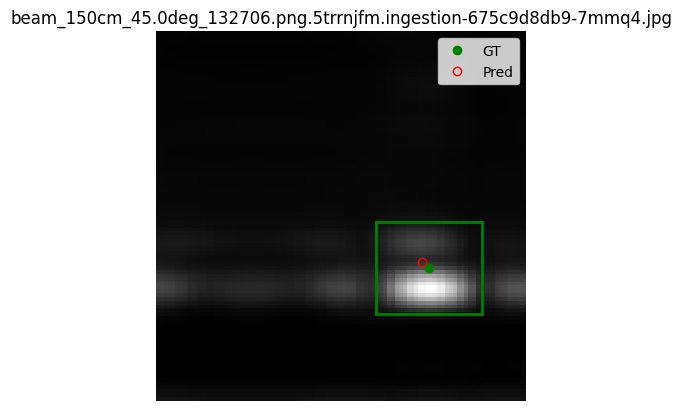

  GT bbox: (56, 48, 27, 24)
  GT center pixel: (70.5, 60.9)
  Pred center px: (70.0, 60.0)
Distance prediction: 150 cm, Angle prediction: 45.0 deg


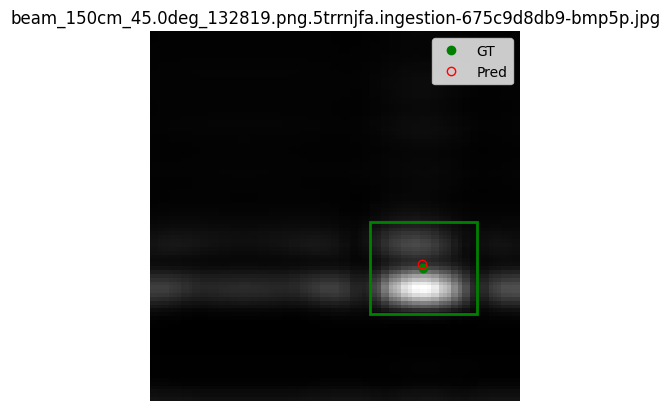

  GT bbox: (73, 48, 22, 24)
  GT center pixel: (84.5, 60.9)
  Pred center px: (84.7, 60.7)
Distance prediction: 150 cm, Angle prediction: 67.5 deg


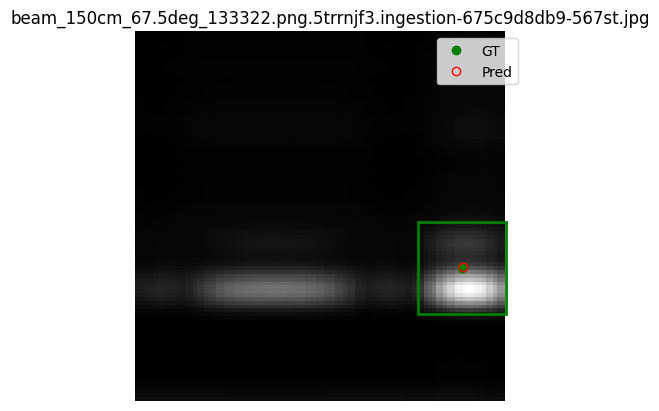

  GT bbox: (73, 48, 22, 23)
  GT center pixel: (84.4, 60.8)
  Pred center px: (84.7, 60.7)
Distance prediction: 150 cm, Angle prediction: 67.5 deg


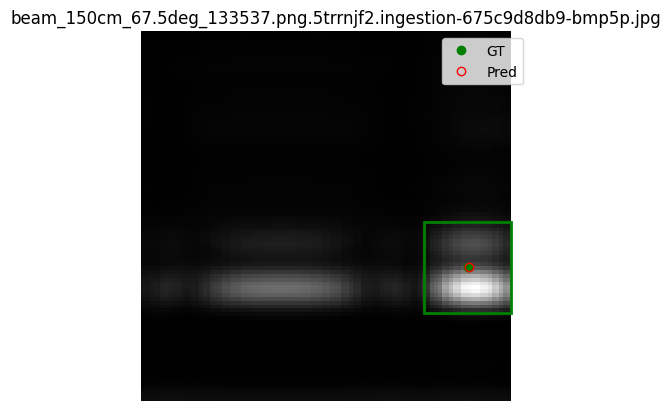

  GT bbox: (39, 9, 30, 24)
  GT center pixel: (55.0, 21.5)
  Pred center px: (54.0, 20.0)
Distance prediction: 350 cm, Angle prediction: 22.5 deg


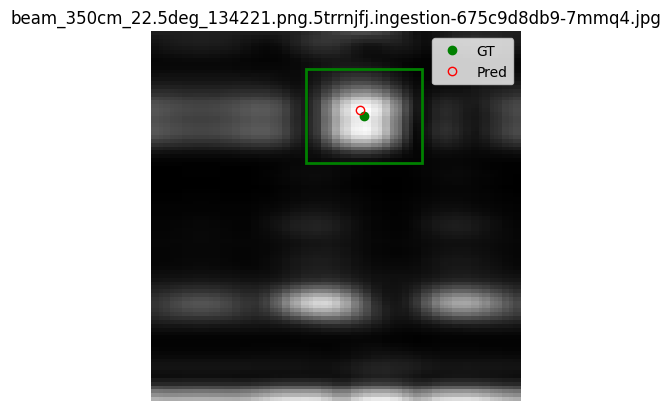

  GT bbox: (74, 48, 21, 27)
  GT center pixel: (85.3, 62.5)
  Pred center px: (85.0, 62.0)
Distance prediction: 150 cm, Angle prediction: 67.5 deg


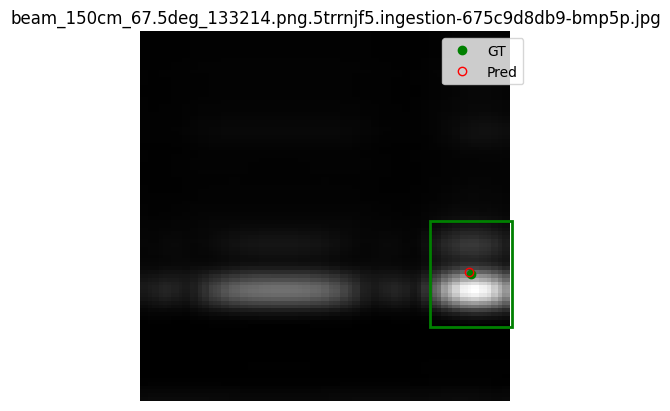

  GT bbox: (54, 10, 31, 24)
  GT center pixel: (70.5, 22.8)
  Pred center px: (68.7, 23.3)
Distance prediction: 350 cm, Angle prediction: 45.0 deg


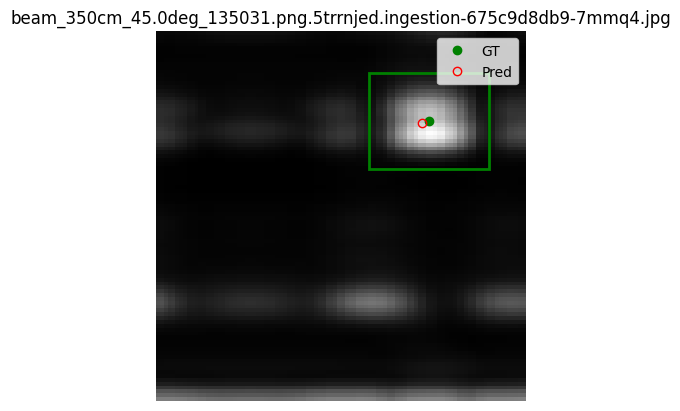

  GT bbox: (54, 48, 30, 24)
  GT center pixel: (69.8, 60.6)
  Pred center px: (68.7, 59.3)
Distance prediction: 150 cm, Angle prediction: 45.0 deg


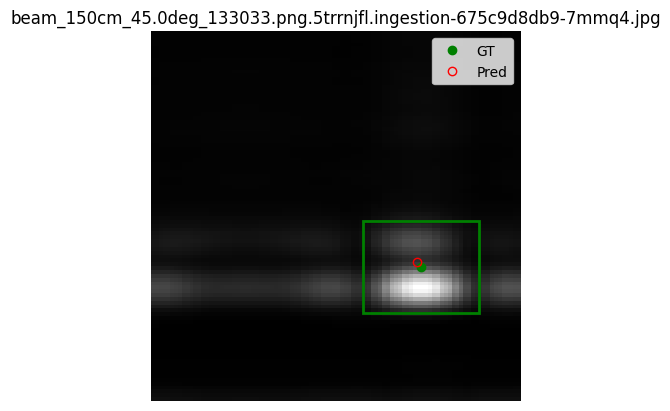

  GT bbox: (70, 48, 25, 24)
  GT center pixel: (83.5, 60.6)
  Pred center px: (84.7, 60.7)
Distance prediction: 150 cm, Angle prediction: 67.5 deg


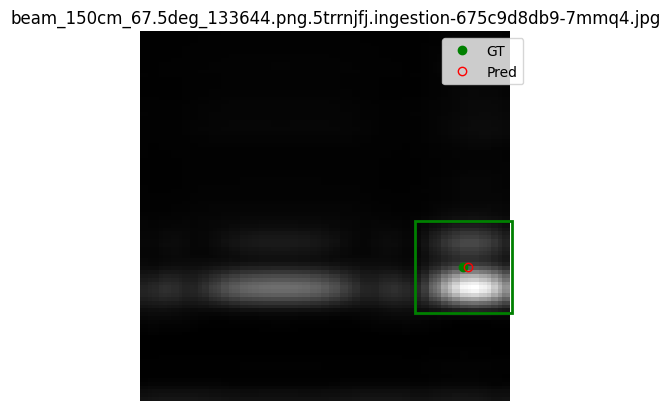

  GT bbox: (41, 9, 25, 24)
  GT center pixel: (54.3, 21.4)
  Pred center px: (54.0, 18.0)
Distance prediction: 350 cm, Angle prediction: 22.5 deg


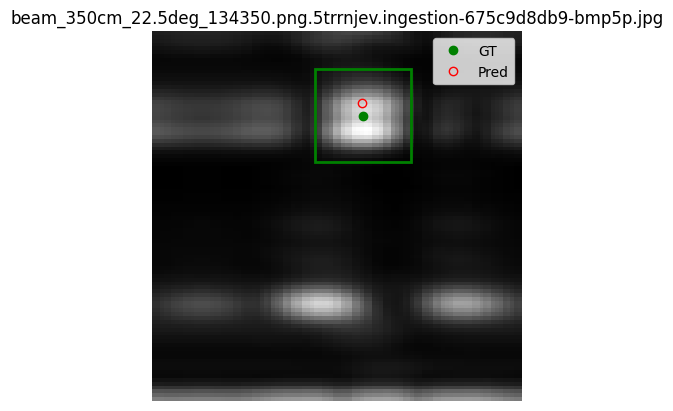

  GT bbox: (72, 49, 23, 26)
  GT center pixel: (84.2, 62.5)
  Pred center px: (84.7, 60.7)
Distance prediction: 150 cm, Angle prediction: 67.5 deg


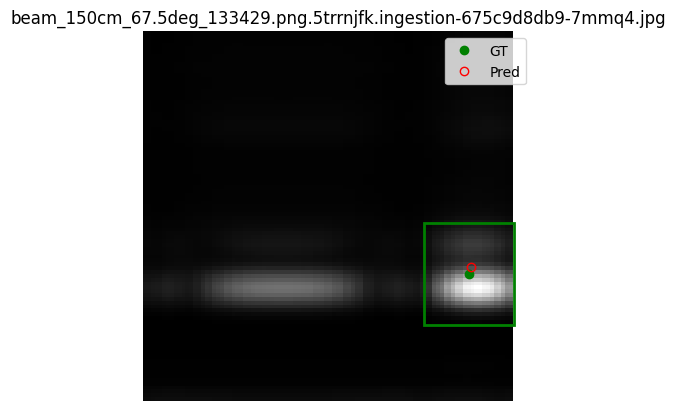

  GT bbox: (38, 7, 31, 27)
  GT center pixel: (54.2, 21.0)
  Pred center px: (54.0, 22.0)
Distance prediction: 350 cm, Angle prediction: 22.5 deg


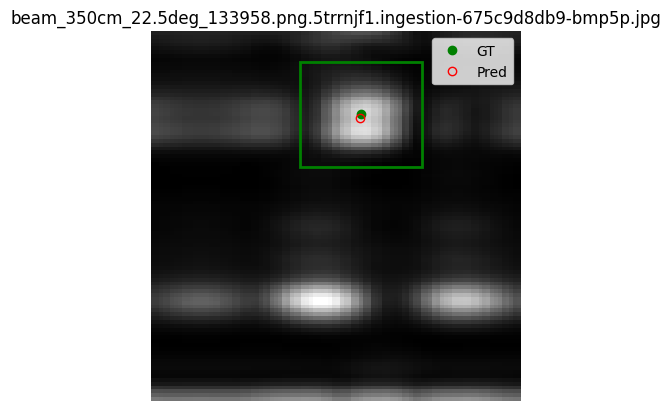

  GT bbox: (56, 46, 26, 27)
  GT center pixel: (69.8, 59.8)
  Pred center px: (70.0, 60.0)
Distance prediction: 150 cm, Angle prediction: 45.0 deg


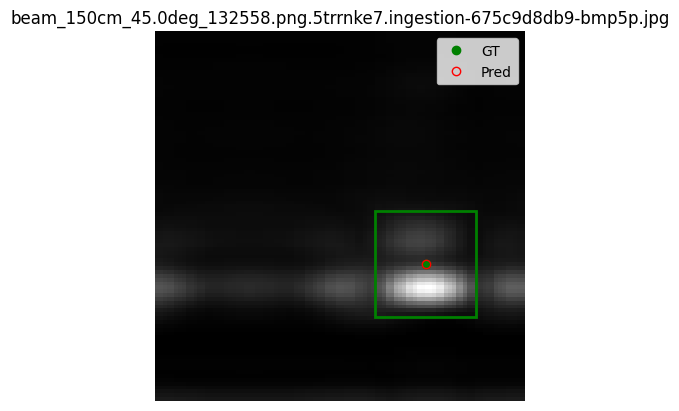

  GT bbox: (41, 45, 26, 27)
  GT center pixel: (54.7, 59.5)
  Pred center px: (56.0, 62.0)
Distance prediction: 150 cm, Angle prediction: 22.5 deg


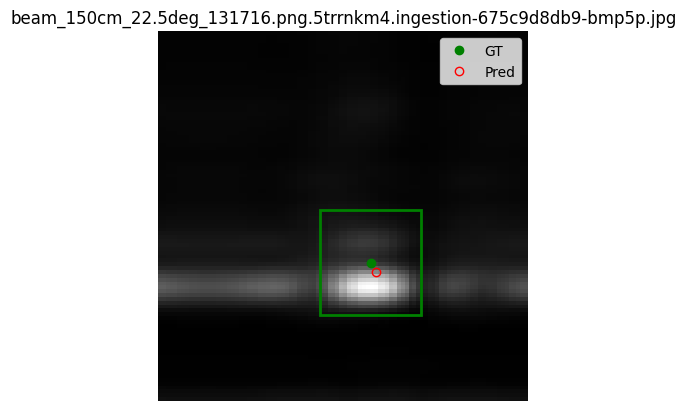

  GT bbox: (40, 45, 26, 27)
  GT center pixel: (54.0, 59.5)
  Pred center px: (56.0, 62.0)
Distance prediction: 150 cm, Angle prediction: 22.5 deg


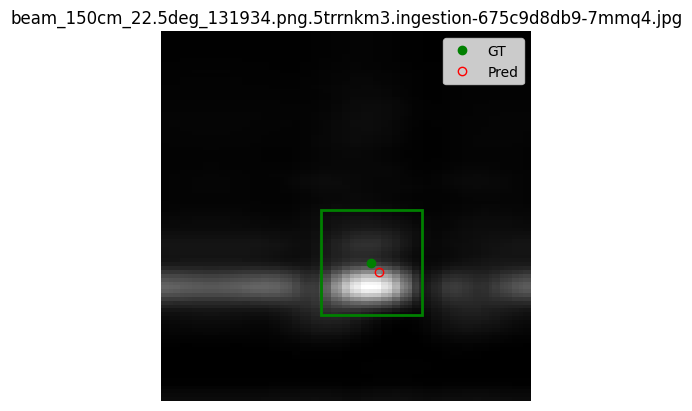

  GT bbox: (40, 45, 26, 27)
  GT center pixel: (54.0, 59.5)
  Pred center px: (54.0, 60.0)
Distance prediction: 150 cm, Angle prediction: 22.5 deg


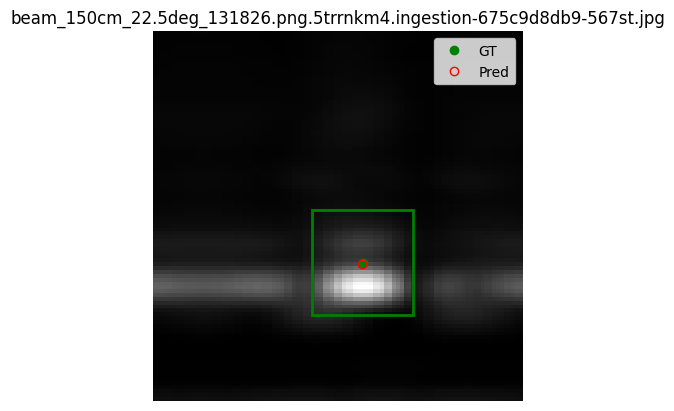

  GT bbox: (40, 45, 28, 29)
  GT center pixel: (54.8, 60.3)
  Pred center px: (56.0, 62.0)
Distance prediction: 150 cm, Angle prediction: 22.5 deg


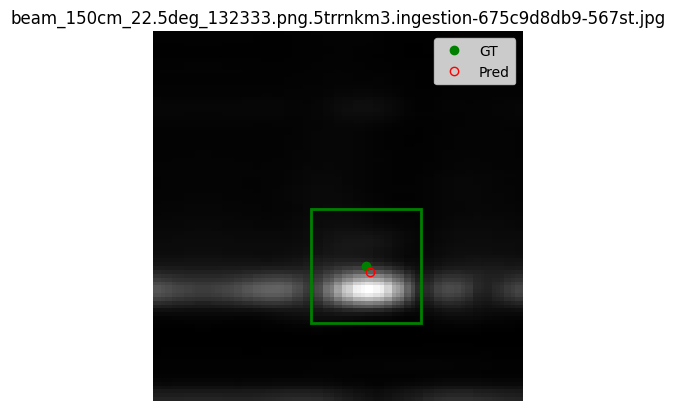

  GT bbox: (40, 45, 26, 28)
  GT center pixel: (54.3, 59.8)
  Pred center px: (56.0, 62.0)
Distance prediction: 150 cm, Angle prediction: 22.5 deg


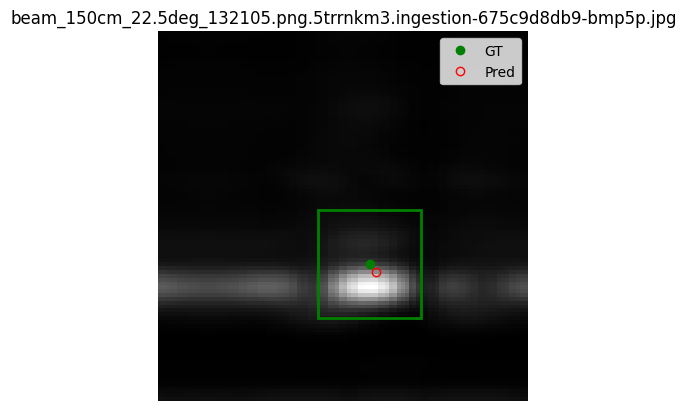

  GT bbox: (40, 44, 27, 28)
  GT center pixel: (54.0, 58.6)
  Pred center px: (54.0, 62.0)
Distance prediction: 150 cm, Angle prediction: 22.5 deg


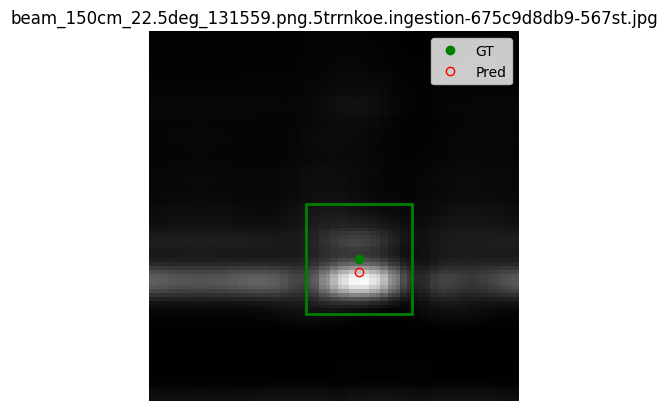


 Metrics 
True Positives: 46, False Positives: 1, False Negatives: 0
Accuracy: 0.98, Rappel: 1.00, F1-score: 0.99
Average distance: 2.99 pixels
Angle + distance accuracy: 0.98
Total RAM used (MB): 794.36328125
== End of inference ==


In [9]:
# Load model
tflite_size = os.path.getsize("fomo96p01.tflite") / 1024  # en KB
print(f"TFLite model size: {tflite_size:.2f} KB")
interpreter = tf.lite.Interpreter(model_path="fomo96p01.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_height, input_width = input_details[0]['shape'][1:3] if input_details[0]['shape'][1] != 3 else input_details[0]['shape'][2:4]
input_is_nchw = input_details[0]['shape'][1] == 3
total_ram_usage = 0.0
# === Inference ===
#  Initialisation
threshold = 10
tp = fp = fn = 0
total_dist = 0
count = 0
correct_both = 0
total_valid = 0
total_ram_usage = 0.0

# Loop
for idx, rel_path in enumerate(test_annotations):
    img_path = os.path.join(images_dir, rel_path)
    img = Image.open(img_path).convert('RGB')
    img_resized = img.resize((96, 96))
    img_np = np.array(img_resized).astype(np.float32) / 255.0

    # NCHW or NHWC : Here [1,3,96,96]
    if input_is_nchw:
        input_tensor = np.transpose(img_np, (2, 0, 1))[np.newaxis, ...]
    else:
        input_tensor = img_np[np.newaxis, ...]

    # Inference TFLite

    interpreter.set_tensor(input_details[0]['index'], input_tensor.astype(np.float32))
    interpreter.invoke()
    #RAM
    ram_used_mb = process.memory_info().rss / (1024 * 1024) - ram_baseline
    ram_usage_list.append(ram_used_mb)

    output_data = interpreter.get_tensor(output_details[0]['index'])[0, 0]

    # Resize for visualisation
    preds_bin = output_data > 0.5
    centroid = get_largest_blob_centroid(preds_bin, (96, 96), output_data.shape)

    # current, peak = tracemalloc.get_traced_memory()
    # ram_used_mb = peak /1024
    # total_ram_usage += ram_used_mb
    filename = os.path.basename(rel_path)

    polar = extract_polar_from_filename(filename)

    #  Ground truth
    if len(test_annotations[rel_path]) > 0:
        gt_x0, gt_y0, gt_w, gt_h = test_annotations[rel_path][0]
        cx = gt_x0 + gt_w / 2
        cy = gt_y0 + gt_h / 2
        bbox_size = max(gt_w, gt_h)
        print(f"  GT bbox: ({int(gt_x0)}, {int(gt_y0)}, {int(gt_w)}, {int(gt_h)})")
        print(f"  GT center pixel: ({cx:.1f}, {cy:.1f})")
    else:
        print("  GT bbox info: N/A")
        cx = cy = -1
        bbox_size = 40

    # Prediction
    if centroid is not None:
        cx_p, cy_p = centroid
        print(f"  Pred center px: ({cx_p:.1f}, {cy_p:.1f})")
    else:
        print("  Predicted: No object found")
        total_valid += 1

    #  Evaluation
    if centroid is not None and cx >= 0:
        dist_px = sqrt((cx - cx_p)**2 + (cy - cy_p)**2)
        total_dist += dist_px
        count += 1
        if dist_px < threshold:
            tp += 1
        else:
            fp += 1
    elif centroid is not None:
        fp += 1
    elif cx >= 0:
        fn += 1

    if centroid is not None and cx >= 0:
        pred_dist_cm, pred_angle_deg = pixel_to_polar(cx_p, cy_p, (96, 96))
        # true_dist_cm, true_angle_deg = pixel_to_polar(cx, cy, (H_img, W_img))

        pred_dist_class = assign_to_nearest(pred_dist_cm, valid_distances)
        # true_dist_class = assign_to_nearest(true_dist_cm, valid_distances)

        pred_angle_class = assign_to_nearest(pred_angle_deg, valid_angles)
        # true_angle_class = assign_to_nearest(true_angle_deg, valid_angles)

        true_dist_class, true_angle_class = polar
        if pred_dist_class == true_dist_class and pred_angle_class == true_angle_class:
            correct_both += 1
        total_valid += 1
        print(f"Distance prediction: {pred_dist_class} cm, Angle prediction: {pred_angle_class} deg")


    #  Visualisation
    fig, ax = plt.subplots()
    ax.imshow(np.array(img_resized))
    if cx >= 0:
        ax.add_patch(plt.Rectangle((gt_x0, gt_y0), gt_w, gt_h, edgecolor='green', facecolor='none', linewidth=2))
        ax.plot(cx, cy, 'go', label='GT')
    if centroid is not None:
        ax.plot(cx_p, cy_p, 'ro', markerfacecolor='none', label='Pred')
    ax.set_title(filename)
    ax.legend(loc='upper right')
    ax.axis('off')
    plt.show()

#  Final result
precision = tp / (tp + fp + 1e-6)
recall = tp / (tp + fn + 1e-6)
f1 = 2 * precision * recall / (precision + recall + 1e-6)
avg_dist = total_dist / count if count > 0 else float('inf')
accuracy_polar_class = correct_both / total_valid if total_valid > 0 else 0

print("\n Metrics ")
print(f"True Positives: {tp}, False Positives: {fp}, False Negatives: {fn}")
print(f"Accuracy: {precision:.2f}, Rappel: {recall:.2f}, F1-score: {f1:.2f}")
print(f"Average distance: {avg_dist:.2f} pixels")
print(f"Angle + distance accuracy: {accuracy_polar_class:.2f}")
RAM1 = psutil.Process().memory_info().rss / (1024 * 1024)

print("Total RAM used (MB):", RAM1)
print("== End of inference ==")


# Test with 0.5 s records

TFLite model size: 24.05 KB
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[beam_250cm_67.5deg_141912split1.png] Pred → dist: 250, angle: 67.5 | GT → dist: 250, angle: 67.5


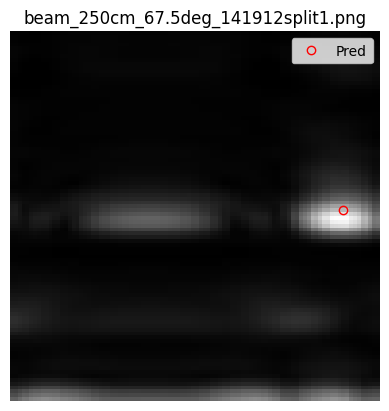

[beam_250cm_67.5deg_141912split2.png] Pred → dist: 250, angle: 67.5 | GT → dist: 250, angle: 67.5


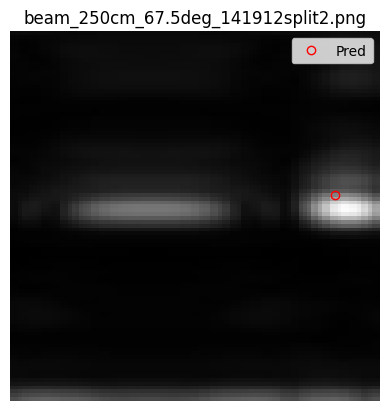

[beam_250cm_67.5deg_141912split3.png] Pred → dist: 250, angle: 67.5 | GT → dist: 250, angle: 67.5


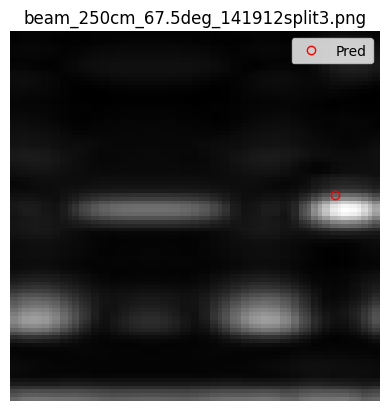

[beam_250cm_67.5deg_141912split4.png] Pred → dist: 250, angle: 67.5 | GT → dist: 250, angle: 67.5


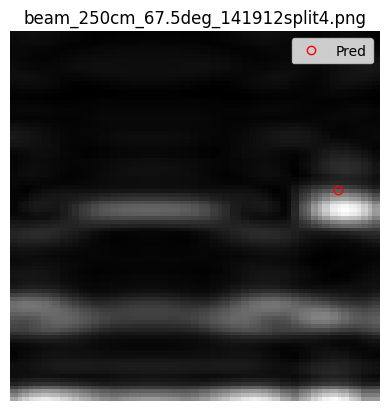

[beam_250cm_67.5deg_141912split5.png] Pred → dist: 250, angle: 67.5 | GT → dist: 250, angle: 67.5


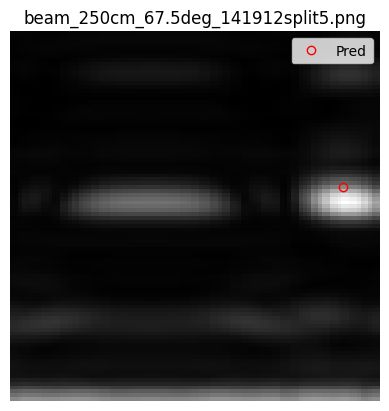

[beam_250cm_67.5deg_142020split1.png] Pred → dist: 250, angle: 67.5 | GT → dist: 250, angle: 67.5


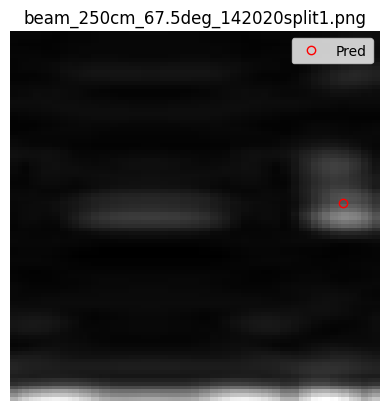

[beam_250cm_67.5deg_142020split2.png] Pred → dist: 250, angle: 67.5 | GT → dist: 250, angle: 67.5


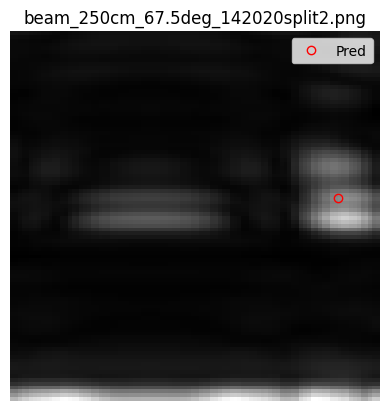

[beam_250cm_67.5deg_142020split3.png] Pred → dist: 250, angle: 67.5 | GT → dist: 250, angle: 67.5


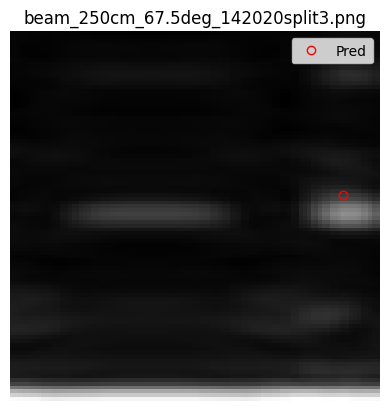

[beam_250cm_67.5deg_142020split4.png] Pred → dist: 250, angle: 67.5 | GT → dist: 250, angle: 67.5


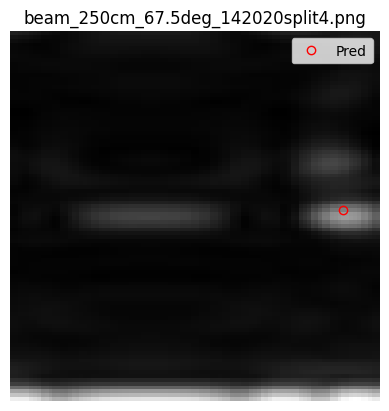

[beam_250cm_67.5deg_142020split5.png] Pred → dist: 250, angle: 67.5 | GT → dist: 250, angle: 67.5


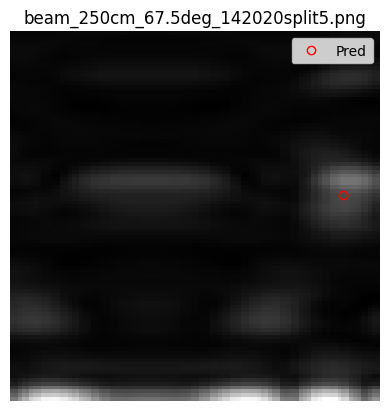

[beam_250cm_45.0deg_141544split1.png] Pred → dist: 250, angle: 45.0 | GT → dist: 250, angle: 45.0


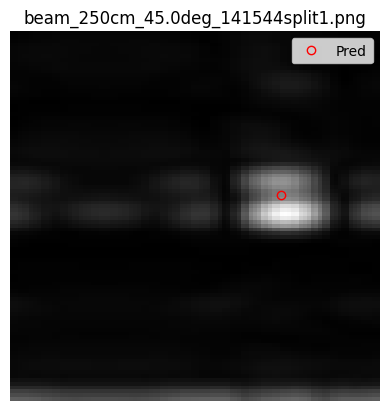

[beam_250cm_45.0deg_141544split2.png] Pred → dist: 250, angle: 45.0 | GT → dist: 250, angle: 45.0


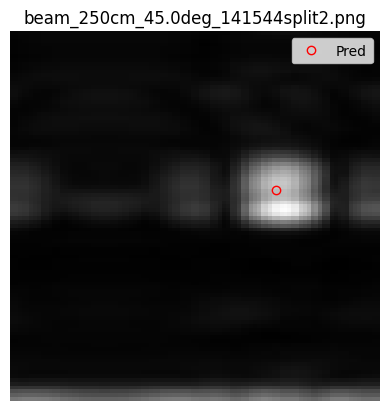

[beam_250cm_45.0deg_141544split3.png] Pred → dist: 250, angle: 45.0 | GT → dist: 250, angle: 45.0


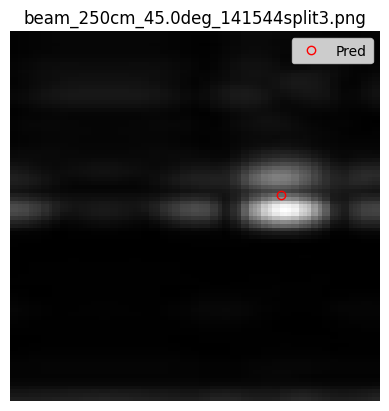

[beam_250cm_45.0deg_141544split4.png] Pred → dist: 350, angle: 45.0 | GT → dist: 250, angle: 45.0


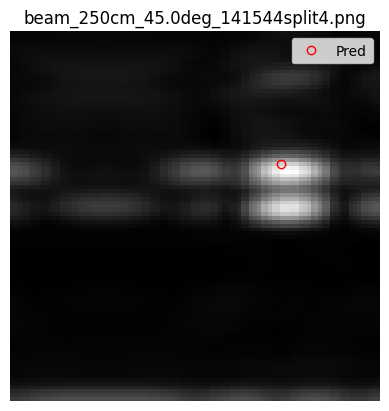

[beam_250cm_45.0deg_141544split5.png] Aucun centroid trouvé.


/tmp/ipython-input-11-1233924682.py:67: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


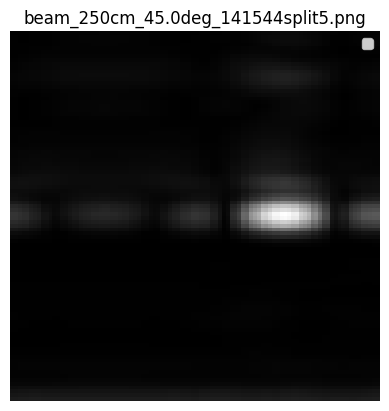

[beam_250cm_67.5deg_141658split1.png] Pred → dist: 350, angle: 67.5 | GT → dist: 250, angle: 67.5


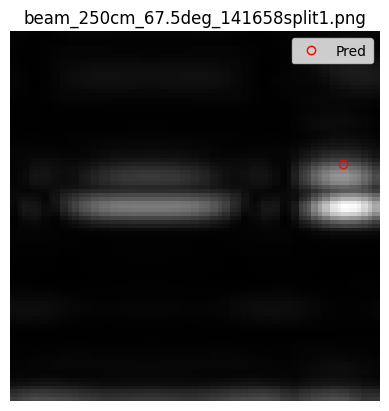

[beam_250cm_67.5deg_141658split2.png] Pred → dist: 250, angle: 67.5 | GT → dist: 250, angle: 67.5


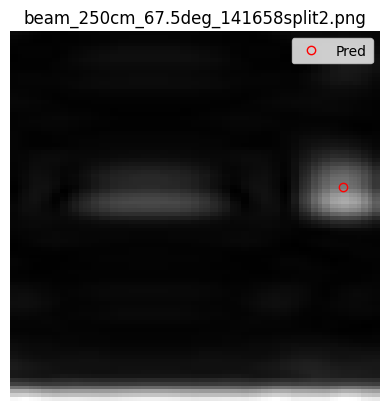

[beam_250cm_67.5deg_141658split3.png] Pred → dist: 350, angle: 67.5 | GT → dist: 250, angle: 67.5


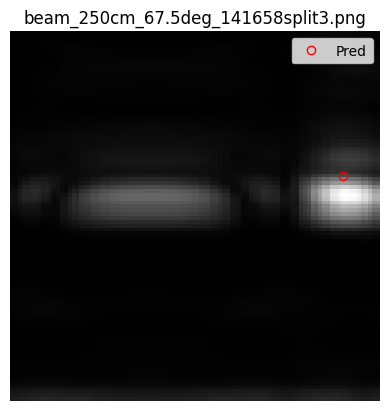

[beam_250cm_67.5deg_141658split4.png] Pred → dist: 250, angle: 67.5 | GT → dist: 250, angle: 67.5


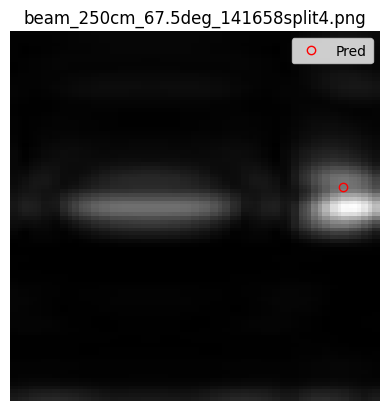

[beam_250cm_67.5deg_141658split5.png] Aucun centroid trouvé.


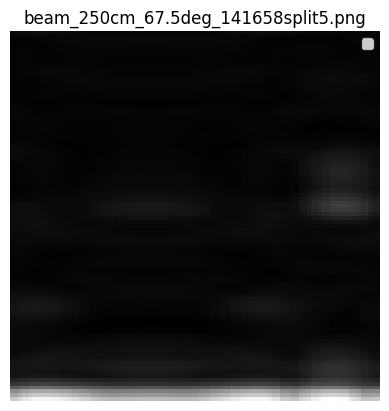

[beam_250cm_45.0deg_141326split1.png] Pred → dist: 350, angle: 45.0 | GT → dist: 250, angle: 45.0


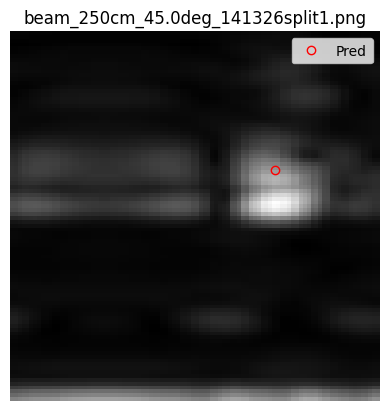

[beam_250cm_45.0deg_141326split2.png] Pred → dist: 250, angle: 45.0 | GT → dist: 250, angle: 45.0


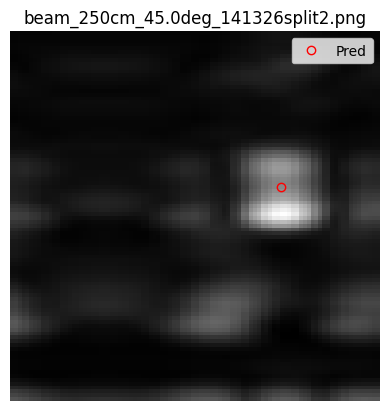

[beam_250cm_45.0deg_141326split3.png] Pred → dist: 350, angle: 45.0 | GT → dist: 250, angle: 45.0


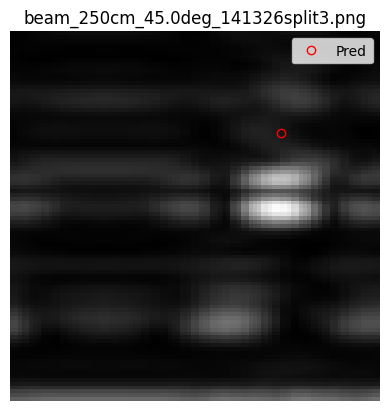

[beam_250cm_45.0deg_141326split4.png] Pred → dist: 350, angle: 45.0 | GT → dist: 250, angle: 45.0


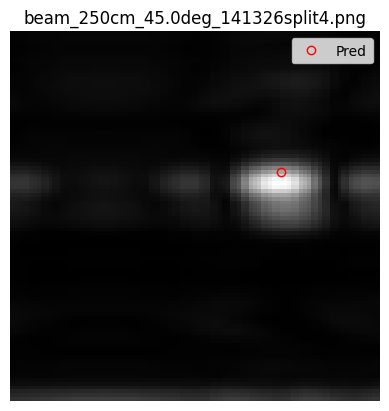

[beam_250cm_45.0deg_141326split5.png] Pred → dist: 250, angle: 45.0 | GT → dist: 250, angle: 45.0


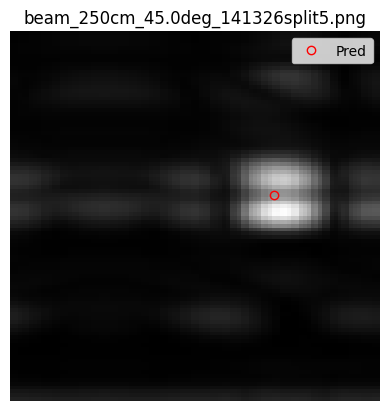

[beam_250cm_67.5deg_141805split1.png] Pred → dist: 250, angle: 67.5 | GT → dist: 250, angle: 67.5


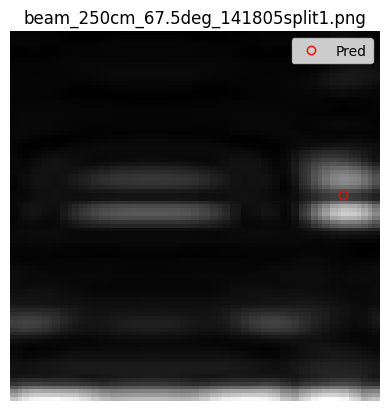

[beam_250cm_67.5deg_141805split2.png] Pred → dist: 250, angle: 67.5 | GT → dist: 250, angle: 67.5


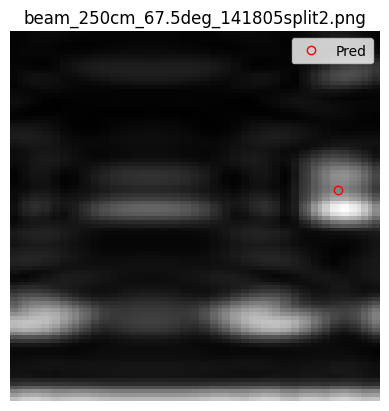

[beam_250cm_67.5deg_141805split3.png] Pred → dist: 350, angle: 67.5 | GT → dist: 250, angle: 67.5


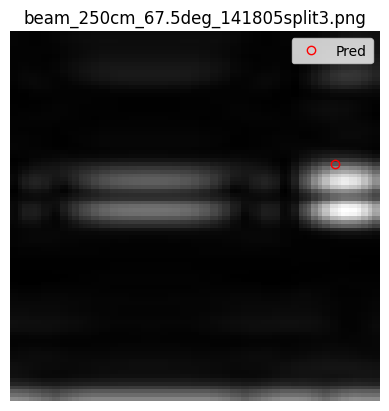

[beam_250cm_67.5deg_141805split4.png] Pred → dist: 150, angle: 45.0 | GT → dist: 250, angle: 67.5


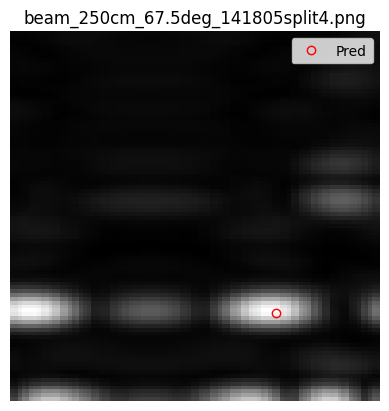

[beam_250cm_67.5deg_141805split5.png] Pred → dist: 150, angle: 22.5 | GT → dist: 250, angle: 67.5


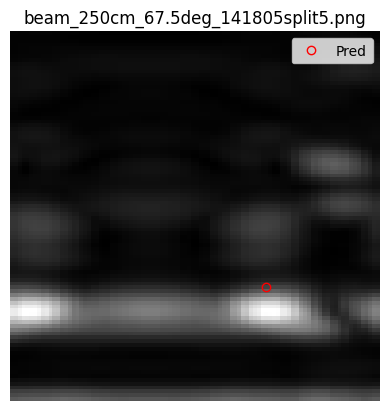

[beam_250cm_67.5deg_142129split1.png] Pred → dist: 250, angle: 67.5 | GT → dist: 250, angle: 67.5


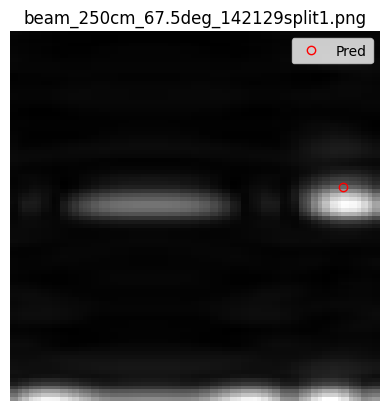

[beam_250cm_67.5deg_142129split2.png] Pred → dist: 250, angle: 67.5 | GT → dist: 250, angle: 67.5


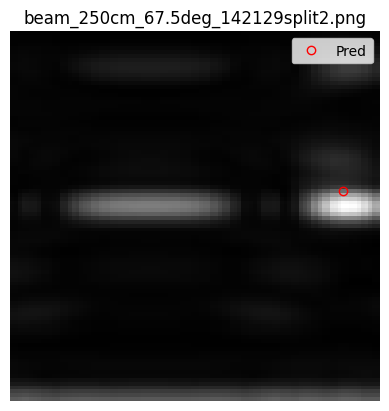

[beam_250cm_67.5deg_142129split3.png] Pred → dist: 250, angle: 67.5 | GT → dist: 250, angle: 67.5


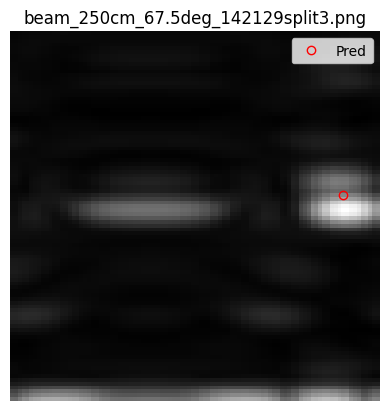

[beam_250cm_67.5deg_142129split4.png] Pred → dist: 250, angle: 67.5 | GT → dist: 250, angle: 67.5


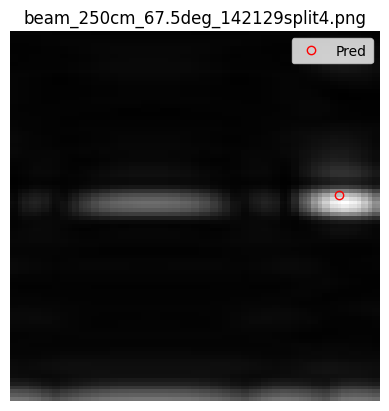

[beam_250cm_67.5deg_142129split5.png] Pred → dist: 250, angle: 67.5 | GT → dist: 250, angle: 67.5


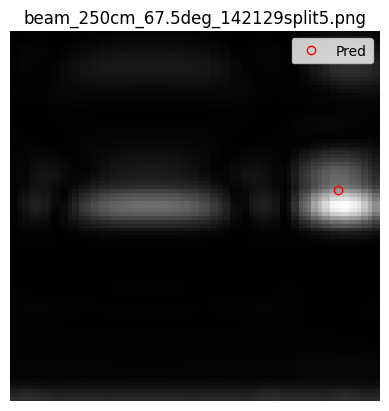

[beam_250cm_45.0deg_141436split1.png] Pred → dist: 350, angle: 45.0 | GT → dist: 250, angle: 45.0


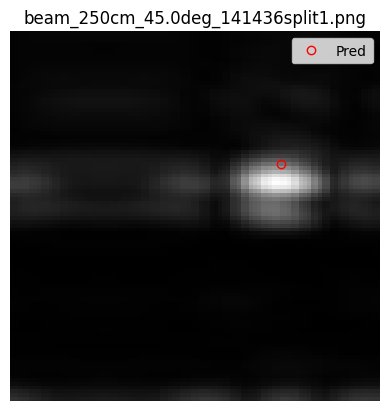

[beam_250cm_45.0deg_141436split2.png] Pred → dist: 250, angle: 45.0 | GT → dist: 250, angle: 45.0


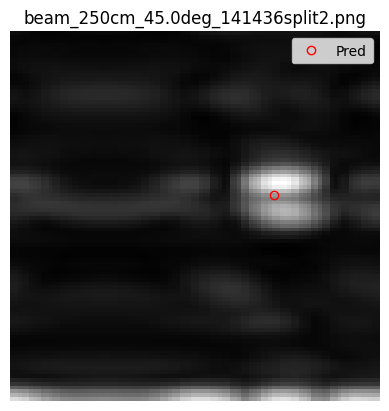

[beam_250cm_45.0deg_141436split3.png] Pred → dist: 250, angle: 45.0 | GT → dist: 250, angle: 45.0


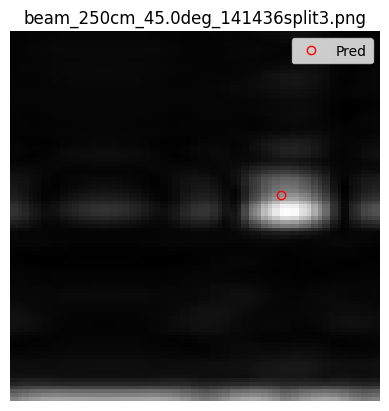

[beam_250cm_45.0deg_141436split4.png] Pred → dist: 250, angle: 45.0 | GT → dist: 250, angle: 45.0


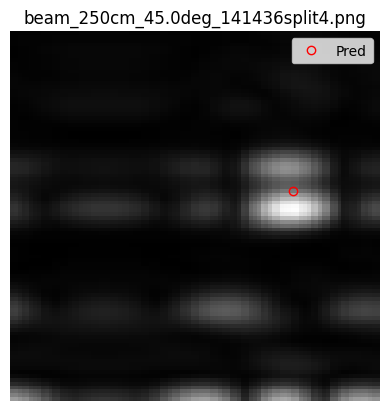

[beam_250cm_45.0deg_141436split5.png] Pred → dist: 150, angle: 22.5 | GT → dist: 250, angle: 45.0


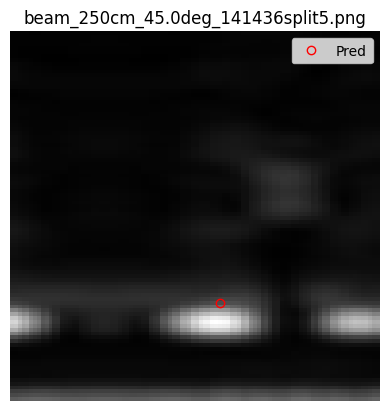

[beam_250cm_45.0deg_141217split1.png] Pred → dist: 250, angle: 45.0 | GT → dist: 250, angle: 45.0


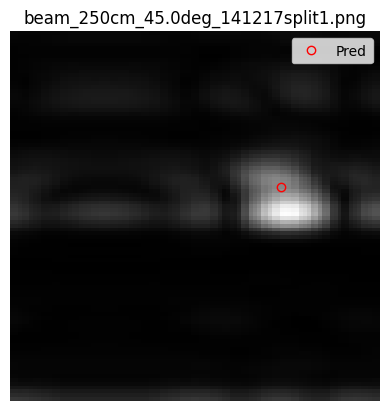

[beam_250cm_45.0deg_141217split2.png] Pred → dist: 250, angle: 45.0 | GT → dist: 250, angle: 45.0


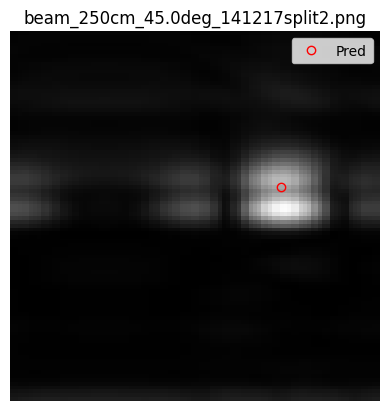

[beam_250cm_45.0deg_141217split3.png] Pred → dist: 250, angle: 45.0 | GT → dist: 250, angle: 45.0


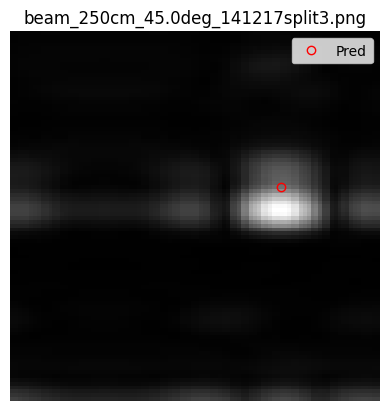

[beam_250cm_45.0deg_141217split4.png] Pred → dist: 250, angle: 45.0 | GT → dist: 250, angle: 45.0


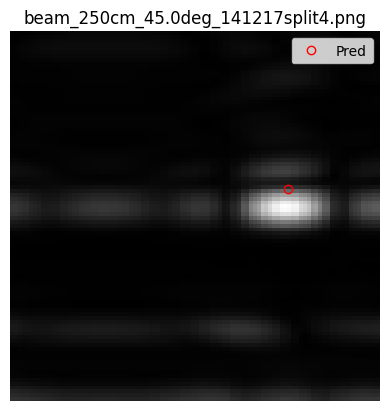

[beam_250cm_45.0deg_141217split5.png] Pred → dist: 250, angle: 45.0 | GT → dist: 250, angle: 45.0


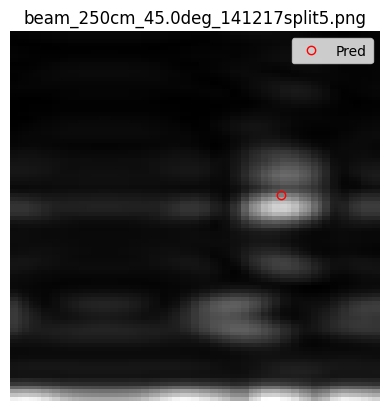

[beam_250cm_22.5deg_140031split1.png] Pred → dist: 350, angle: 22.5 | GT → dist: 250, angle: 22.5


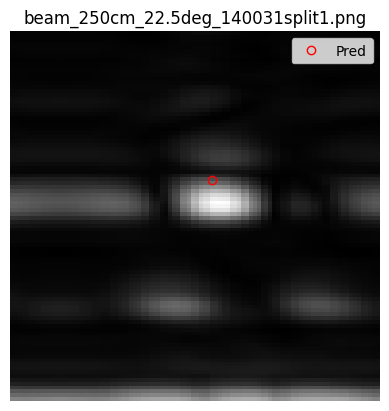

[beam_250cm_22.5deg_140031split2.png] Pred → dist: 250, angle: 22.5 | GT → dist: 250, angle: 22.5


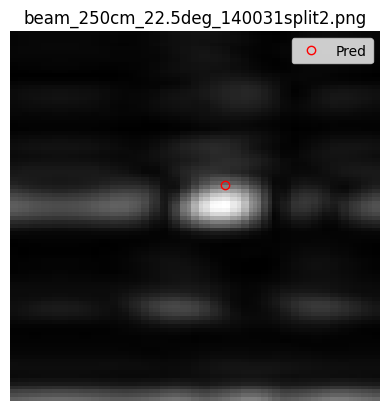

[beam_250cm_22.5deg_140031split3.png] Pred → dist: 150, angle: 22.5 | GT → dist: 250, angle: 22.5


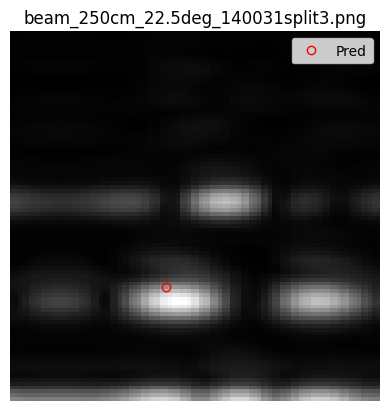

[beam_250cm_22.5deg_140031split4.png] Pred → dist: 250, angle: 22.5 | GT → dist: 250, angle: 22.5


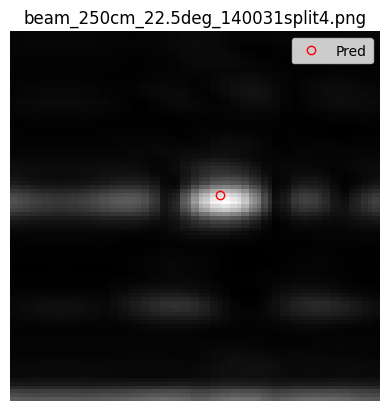

[beam_250cm_22.5deg_140031split5.png] Pred → dist: 250, angle: 22.5 | GT → dist: 250, angle: 22.5


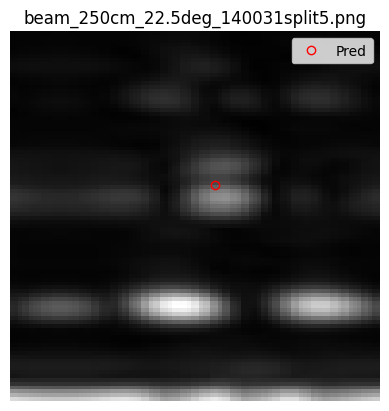

[beam_250cm_22.5deg_140535split1.png] Pred → dist: 350, angle: 22.5 | GT → dist: 250, angle: 22.5


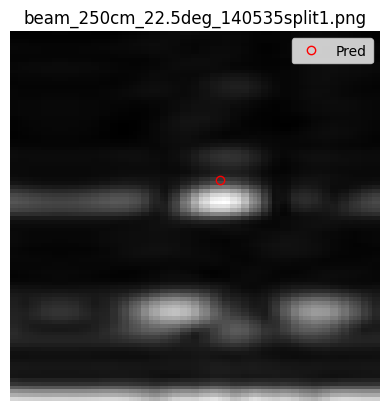

[beam_250cm_22.5deg_140535split2.png] Pred → dist: 250, angle: 22.5 | GT → dist: 250, angle: 22.5


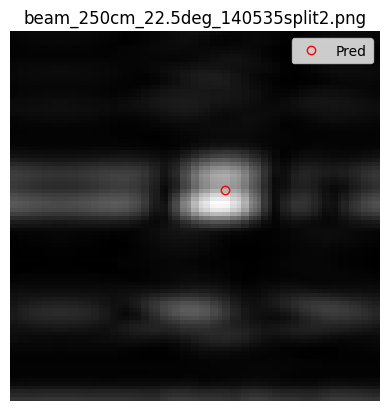

[beam_250cm_22.5deg_140535split3.png] Pred → dist: 250, angle: 22.5 | GT → dist: 250, angle: 22.5


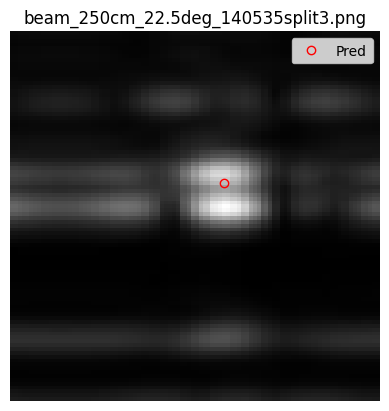

[beam_250cm_22.5deg_140535split4.png] Pred → dist: 350, angle: 22.5 | GT → dist: 250, angle: 22.5


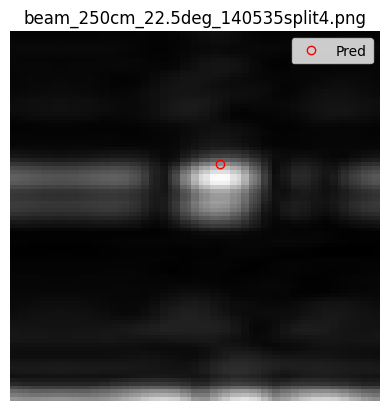

[beam_250cm_22.5deg_140535split5.png] Pred → dist: 250, angle: 22.5 | GT → dist: 250, angle: 22.5


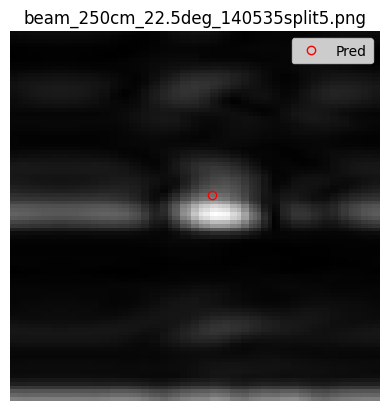

[beam_250cm_45.0deg_141000split1.png] Pred → dist: 150, angle: 67.5 | GT → dist: 250, angle: 45.0


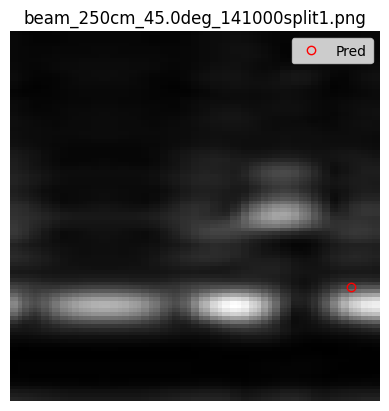

[beam_250cm_45.0deg_141000split2.png] Pred → dist: 250, angle: 45.0 | GT → dist: 250, angle: 45.0


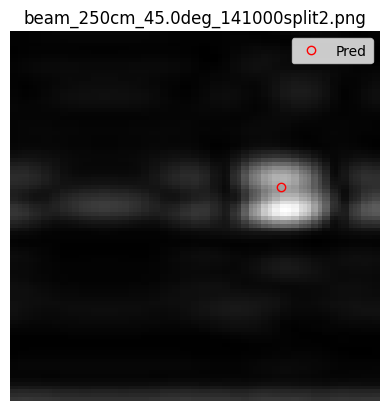

[beam_250cm_45.0deg_141000split3.png] Pred → dist: 250, angle: 45.0 | GT → dist: 250, angle: 45.0


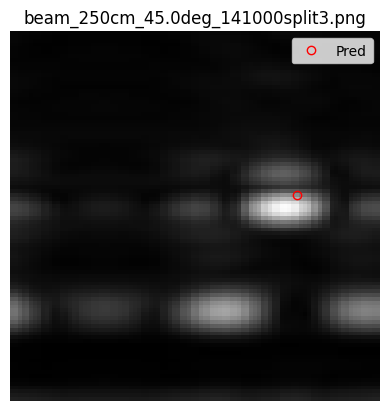

[beam_250cm_45.0deg_141000split4.png] Pred → dist: 250, angle: 45.0 | GT → dist: 250, angle: 45.0


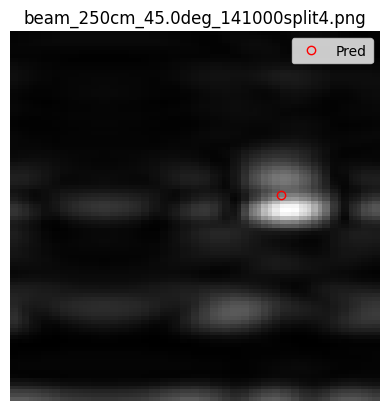

[beam_250cm_45.0deg_141000split5.png] Pred → dist: 250, angle: 45.0 | GT → dist: 250, angle: 45.0


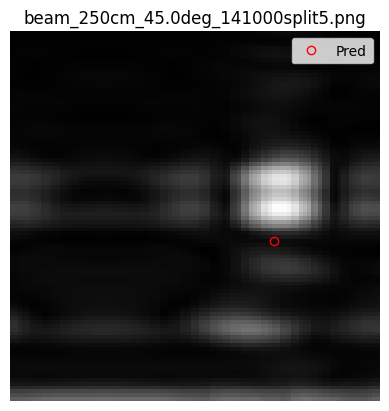

[beam_250cm_22.5deg_140358split1.png] Pred → dist: 250, angle: 22.5 | GT → dist: 250, angle: 22.5


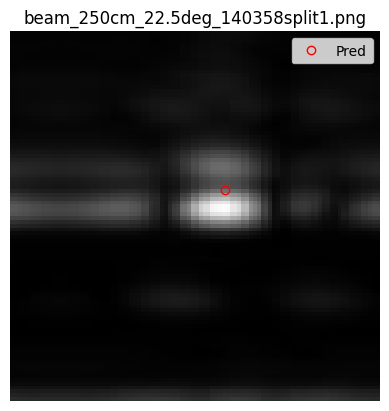

[beam_250cm_22.5deg_140358split2.png] Pred → dist: 250, angle: 22.5 | GT → dist: 250, angle: 22.5


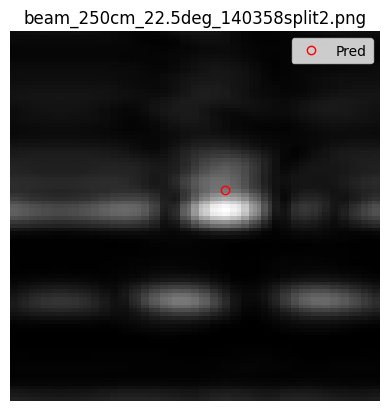

[beam_250cm_22.5deg_140358split3.png] Pred → dist: 250, angle: 22.5 | GT → dist: 250, angle: 22.5


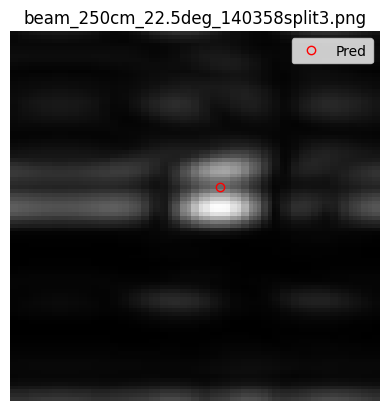

[beam_250cm_22.5deg_140358split4.png] Pred → dist: 350, angle: 22.5 | GT → dist: 250, angle: 22.5


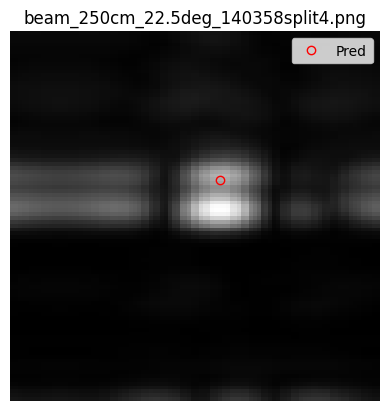

[beam_250cm_22.5deg_140358split5.png] Pred → dist: 250, angle: 22.5 | GT → dist: 250, angle: 22.5


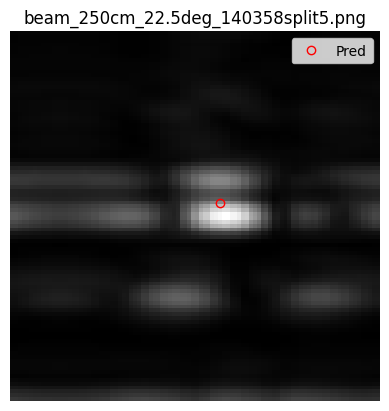

[beam_250cm_45.0deg_141109split1.png] Pred → dist: 250, angle: 45.0 | GT → dist: 250, angle: 45.0


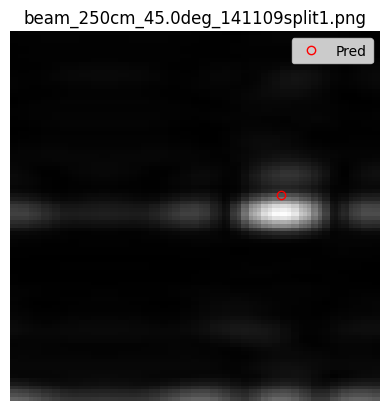

[beam_250cm_45.0deg_141109split2.png] Pred → dist: 150, angle: 22.5 | GT → dist: 250, angle: 45.0


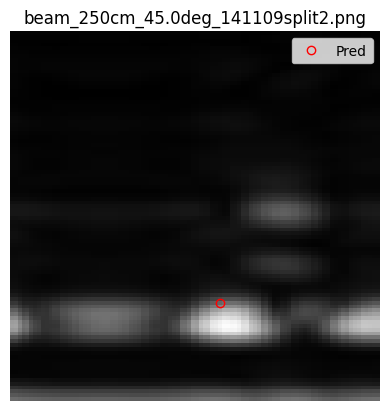

[beam_250cm_45.0deg_141109split3.png] Pred → dist: 250, angle: 45.0 | GT → dist: 250, angle: 45.0


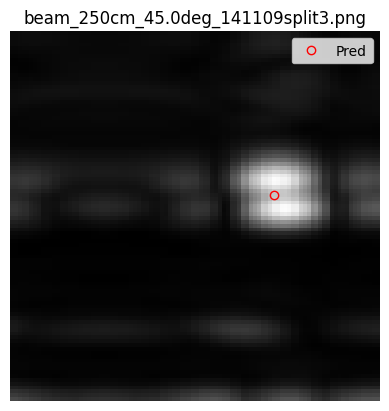

[beam_250cm_45.0deg_141109split4.png] Pred → dist: 250, angle: 45.0 | GT → dist: 250, angle: 45.0


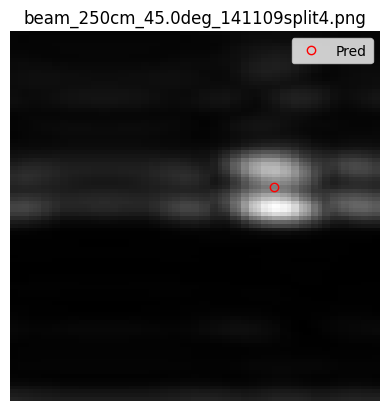

[beam_250cm_45.0deg_141109split5.png] Pred → dist: 150, angle: 22.5 | GT → dist: 250, angle: 45.0


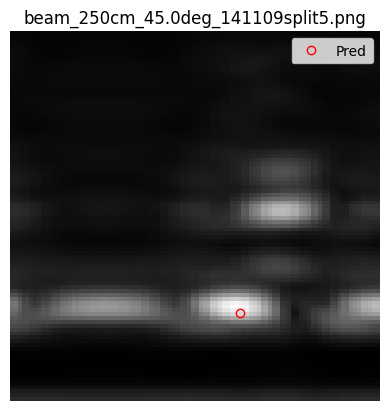

[beam_250cm_22.5deg_140249split1.png] Pred → dist: 250, angle: 22.5 | GT → dist: 250, angle: 22.5


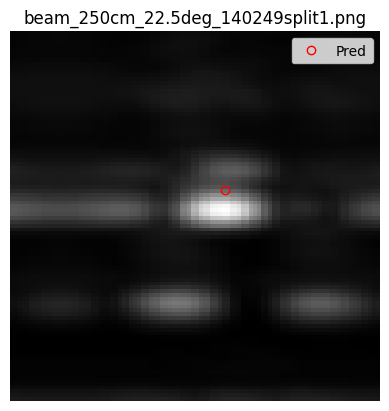

[beam_250cm_22.5deg_140249split2.png] Pred → dist: 250, angle: 22.5 | GT → dist: 250, angle: 22.5


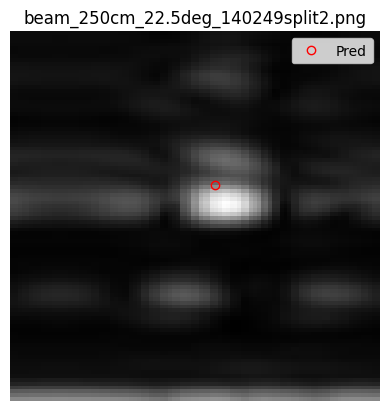

[beam_250cm_22.5deg_140249split3.png] Pred → dist: 250, angle: 22.5 | GT → dist: 250, angle: 22.5


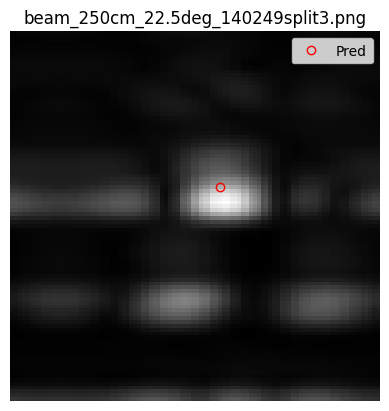

[beam_250cm_22.5deg_140249split4.png] Pred → dist: 250, angle: 22.5 | GT → dist: 250, angle: 22.5


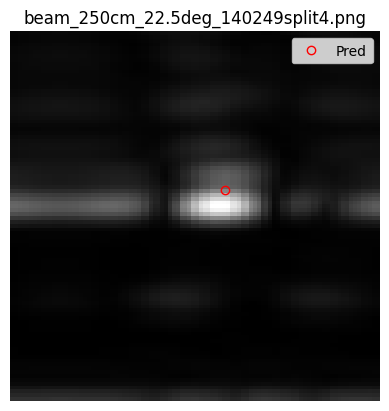

[beam_250cm_22.5deg_140249split5.png] Pred → dist: 350, angle: 22.5 | GT → dist: 250, angle: 22.5


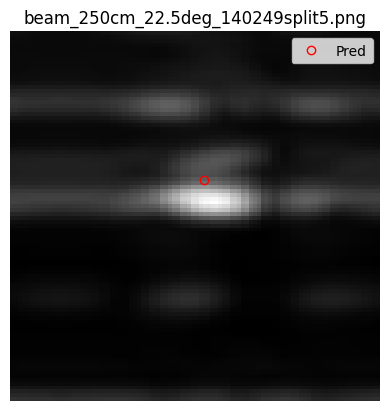

[beam_250cm_22.5deg_140140split1.png] Pred → dist: 250, angle: 22.5 | GT → dist: 250, angle: 22.5


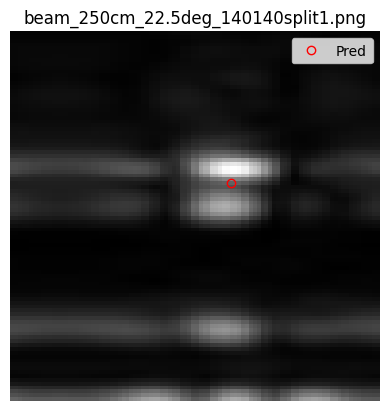

[beam_250cm_22.5deg_140140split2.png] Pred → dist: 250, angle: 22.5 | GT → dist: 250, angle: 22.5


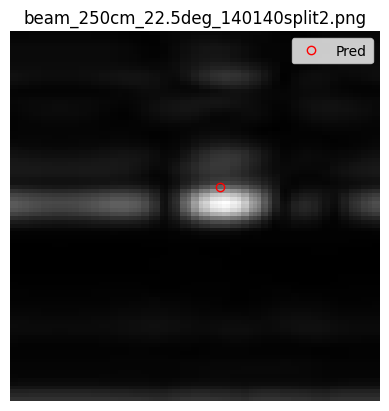

[beam_250cm_22.5deg_140140split3.png] Pred → dist: 250, angle: 22.5 | GT → dist: 250, angle: 22.5


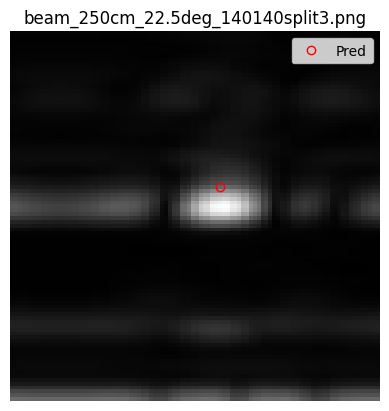

[beam_250cm_22.5deg_140140split4.png] Pred → dist: 150, angle: 22.5 | GT → dist: 250, angle: 22.5


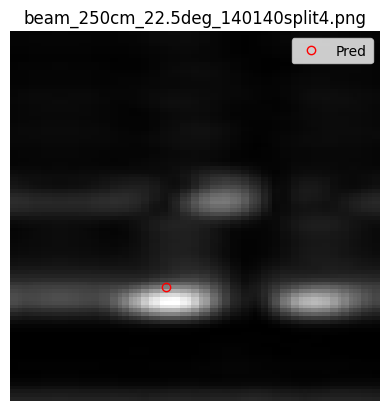

[beam_250cm_22.5deg_140140split5.png] Pred → dist: 250, angle: 22.5 | GT → dist: 250, angle: 22.5


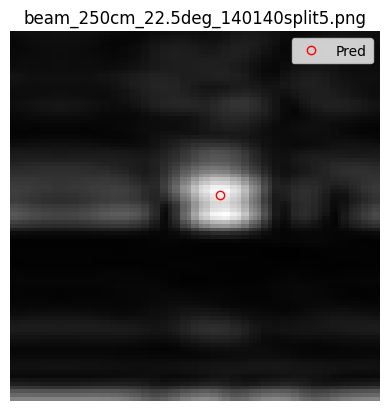

[beam_350cm_67.5deg_135625split1.png] Pred → dist: 350, angle: 67.5 | GT → dist: 350, angle: 67.5


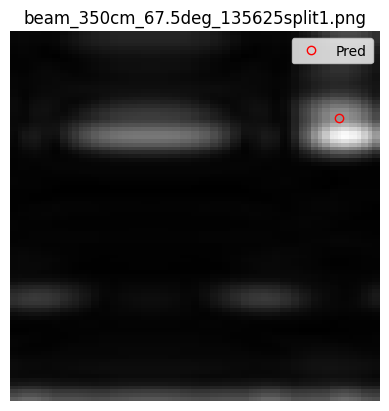

[beam_350cm_67.5deg_135625split2.png] Pred → dist: 350, angle: 67.5 | GT → dist: 350, angle: 67.5


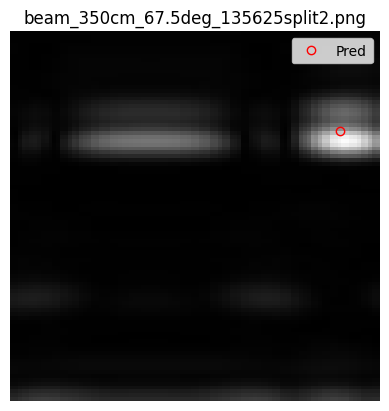

[beam_350cm_67.5deg_135625split3.png] Pred → dist: 350, angle: 67.5 | GT → dist: 350, angle: 67.5


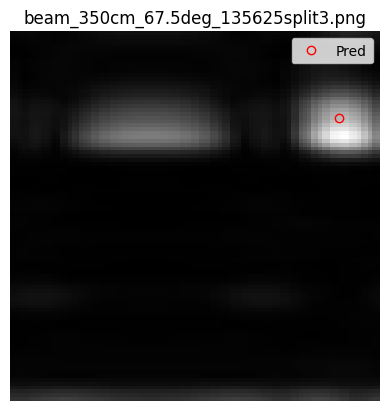

[beam_350cm_67.5deg_135625split4.png] Pred → dist: 350, angle: 67.5 | GT → dist: 350, angle: 67.5


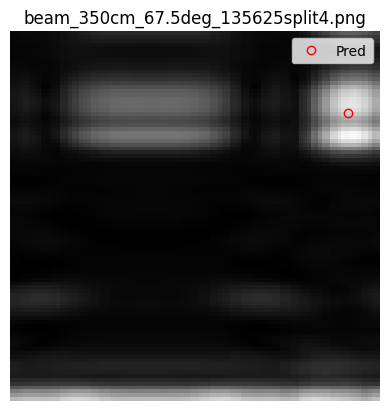

[beam_350cm_67.5deg_135625split5.png] Pred → dist: 350, angle: 67.5 | GT → dist: 350, angle: 67.5


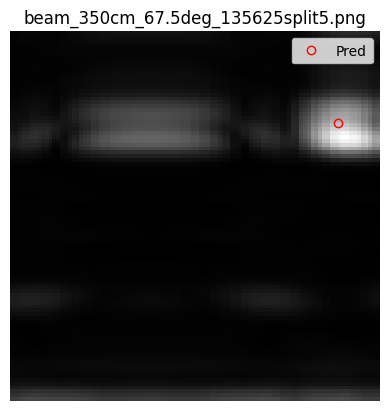

[beam_350cm_67.5deg_135518split1.png] Pred → dist: 350, angle: 67.5 | GT → dist: 350, angle: 67.5


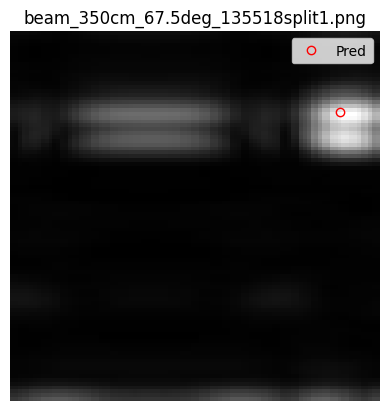

[beam_350cm_67.5deg_135518split2.png] Pred → dist: 350, angle: 67.5 | GT → dist: 350, angle: 67.5


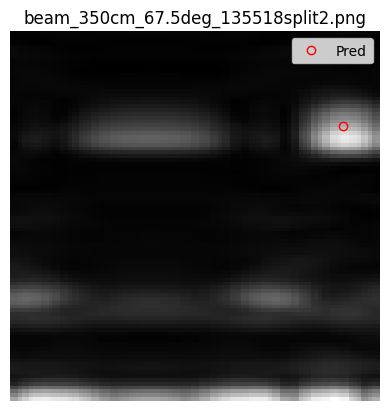

[beam_350cm_67.5deg_135518split3.png] Aucun centroid trouvé.


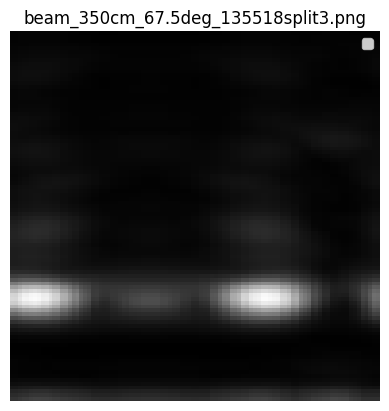

[beam_350cm_67.5deg_135518split4.png] Pred → dist: 350, angle: 67.5 | GT → dist: 350, angle: 67.5


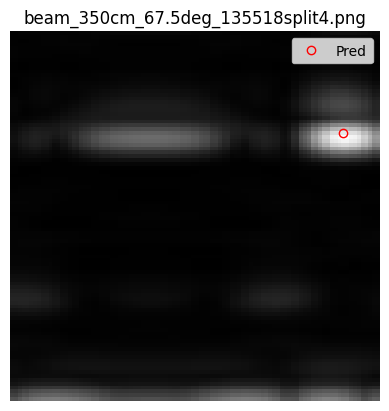

[beam_350cm_67.5deg_135518split5.png] Pred → dist: 350, angle: 67.5 | GT → dist: 350, angle: 67.5


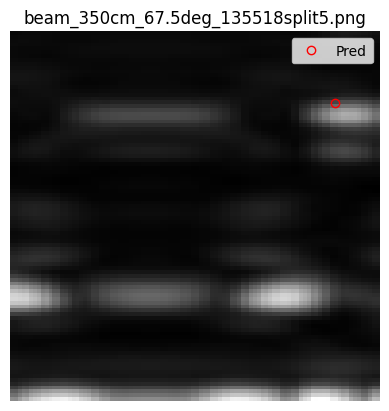

[beam_350cm_67.5deg_135249split1.png] Pred → dist: 350, angle: 67.5 | GT → dist: 350, angle: 67.5


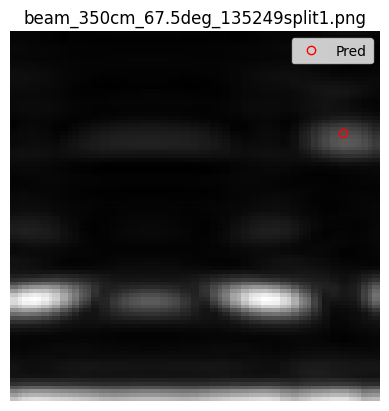

[beam_350cm_67.5deg_135249split2.png] Pred → dist: 150, angle: 67.5 | GT → dist: 350, angle: 67.5


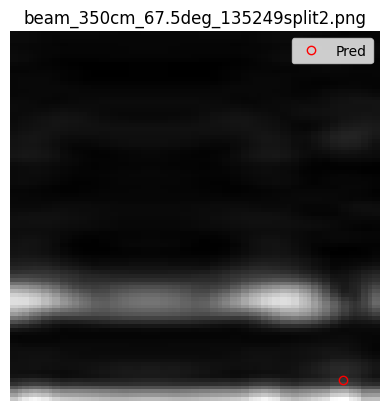

[beam_350cm_67.5deg_135249split3.png] Pred → dist: 350, angle: 67.5 | GT → dist: 350, angle: 67.5


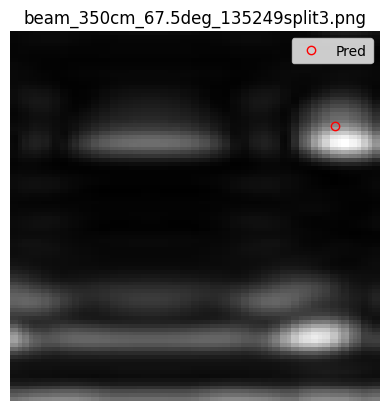

[beam_350cm_67.5deg_135249split4.png] Pred → dist: 350, angle: 67.5 | GT → dist: 350, angle: 67.5


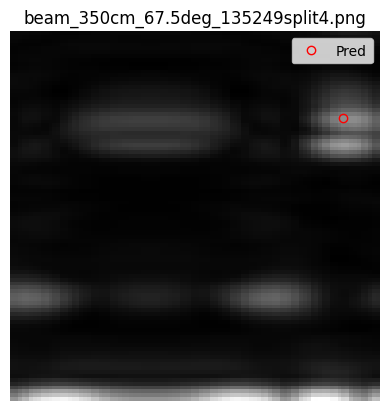

[beam_350cm_67.5deg_135249split5.png] Pred → dist: 150, angle: 45.0 | GT → dist: 350, angle: 67.5


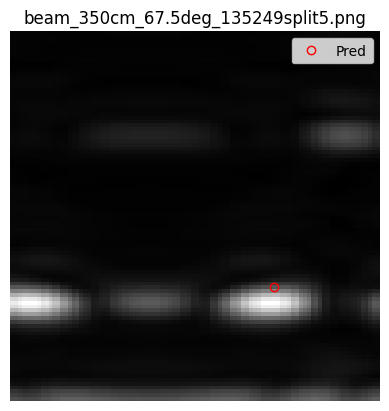

[beam_350cm_67.5deg_135411split1.png] Pred → dist: 350, angle: 67.5 | GT → dist: 350, angle: 67.5


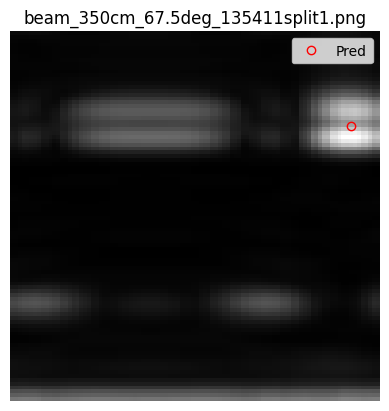

[beam_350cm_67.5deg_135411split2.png] Pred → dist: 350, angle: 67.5 | GT → dist: 350, angle: 67.5


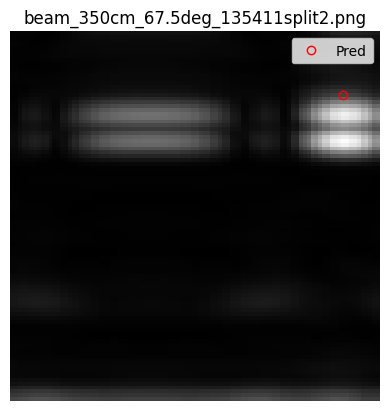

[beam_350cm_67.5deg_135411split3.png] Pred → dist: 350, angle: 67.5 | GT → dist: 350, angle: 67.5


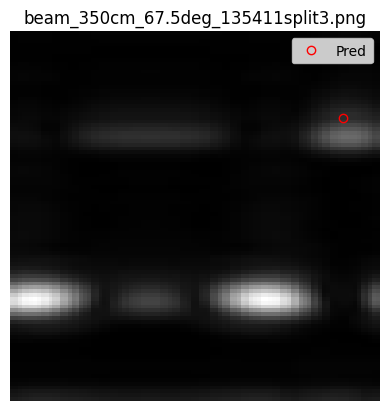

[beam_350cm_67.5deg_135411split4.png] Pred → dist: 350, angle: 67.5 | GT → dist: 350, angle: 67.5


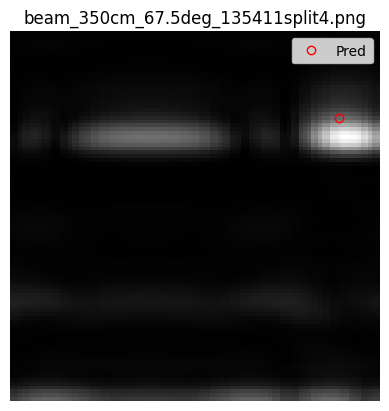

[beam_350cm_67.5deg_135411split5.png] Pred → dist: 350, angle: 67.5 | GT → dist: 350, angle: 67.5


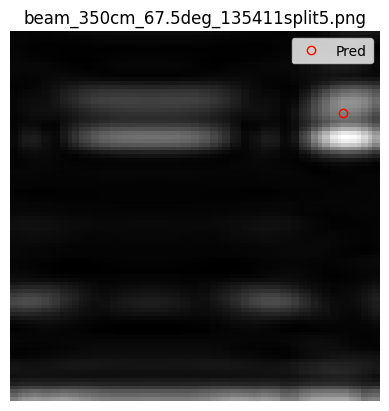

[beam_350cm_45.0deg_135031split1.png] Pred → dist: 350, angle: 45.0 | GT → dist: 350, angle: 45.0


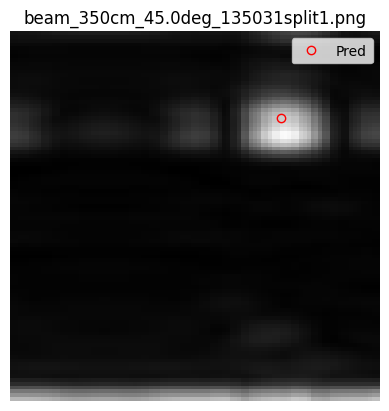

[beam_350cm_45.0deg_135031split2.png] Pred → dist: 350, angle: 45.0 | GT → dist: 350, angle: 45.0


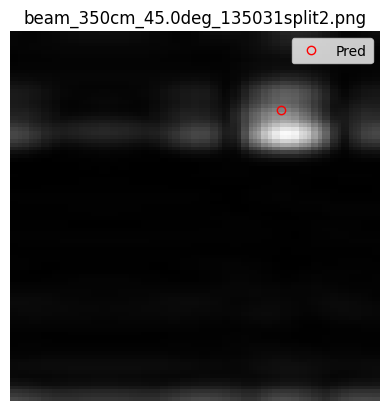

[beam_350cm_45.0deg_135031split3.png] Pred → dist: 350, angle: 45.0 | GT → dist: 350, angle: 45.0


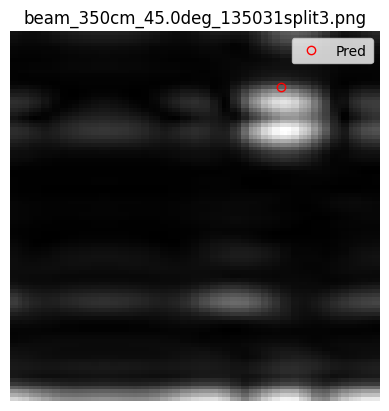

[beam_350cm_45.0deg_135031split4.png] Pred → dist: 350, angle: 22.5 | GT → dist: 350, angle: 45.0


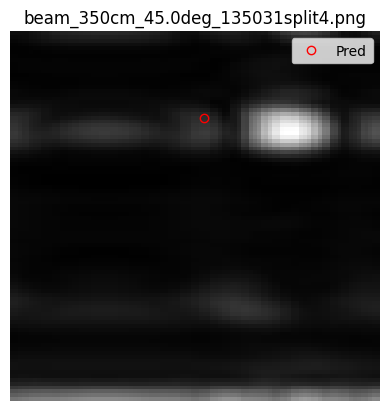

[beam_350cm_45.0deg_135031split5.png] Pred → dist: 350, angle: 45.0 | GT → dist: 350, angle: 45.0


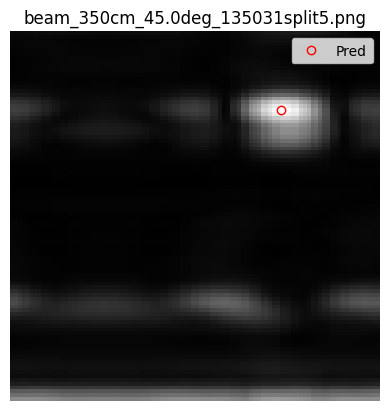

[beam_350cm_67.5deg_135142split1.png] Pred → dist: 350, angle: 67.5 | GT → dist: 350, angle: 67.5


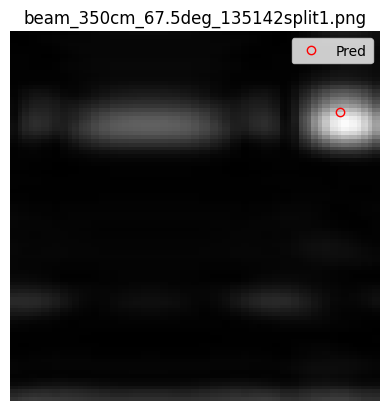

[beam_350cm_67.5deg_135142split2.png] Pred → dist: 350, angle: 67.5 | GT → dist: 350, angle: 67.5


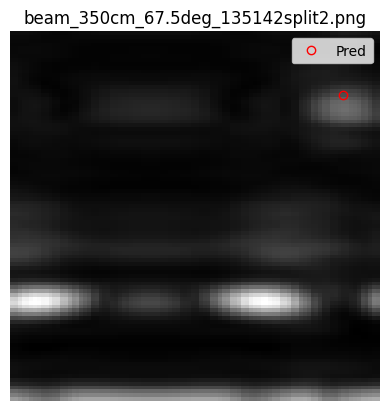

[beam_350cm_67.5deg_135142split3.png] Pred → dist: 350, angle: 67.5 | GT → dist: 350, angle: 67.5


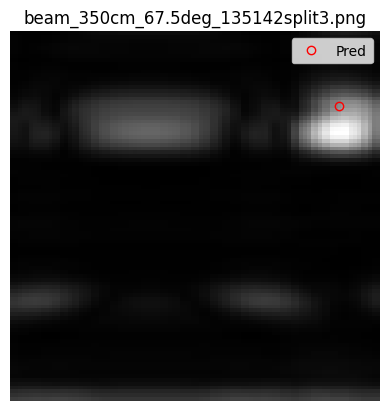

[beam_350cm_67.5deg_135142split4.png] Pred → dist: 150, angle: 22.5 | GT → dist: 350, angle: 67.5


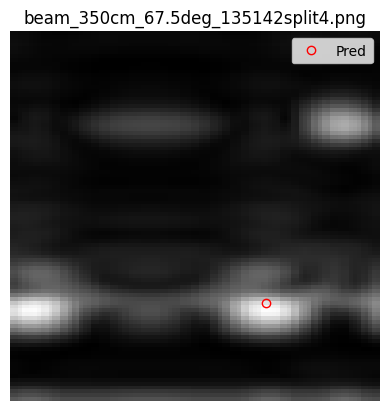

[beam_350cm_67.5deg_135142split5.png] Pred → dist: 350, angle: 67.5 | GT → dist: 350, angle: 67.5


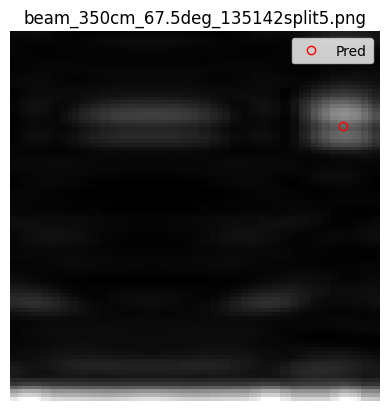

[beam_350cm_45.0deg_134722split1.png] Pred → dist: 350, angle: 45.0 | GT → dist: 350, angle: 45.0


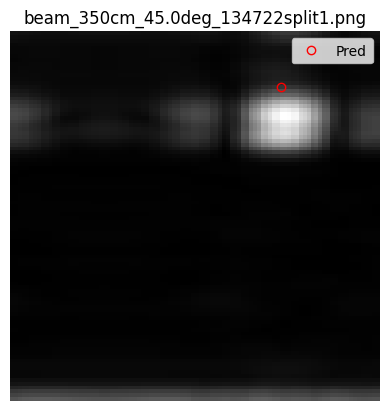

[beam_350cm_45.0deg_134722split2.png] Aucun centroid trouvé.


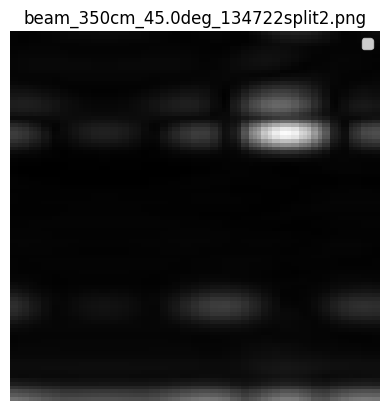

[beam_350cm_45.0deg_134722split3.png] Pred → dist: 350, angle: 22.5 | GT → dist: 350, angle: 45.0


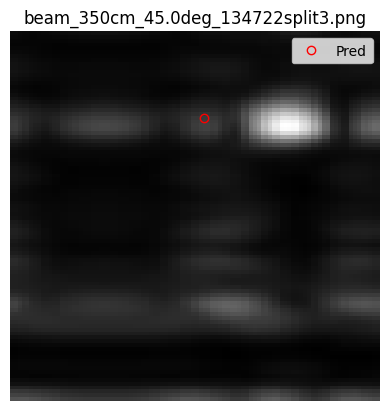

[beam_350cm_45.0deg_134722split4.png] Pred → dist: 350, angle: 45.0 | GT → dist: 350, angle: 45.0


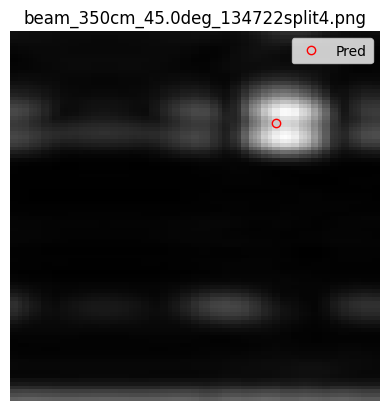

[beam_350cm_45.0deg_134722split5.png] Pred → dist: 350, angle: 45.0 | GT → dist: 350, angle: 45.0


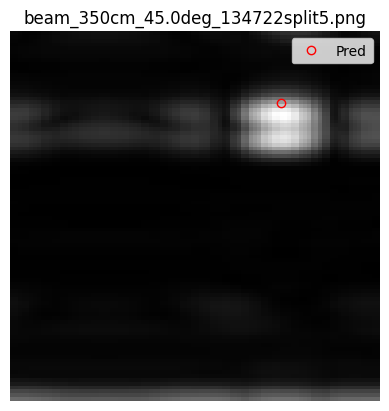

[beam_350cm_45.0deg_134610split1.png] Pred → dist: 350, angle: 45.0 | GT → dist: 350, angle: 45.0


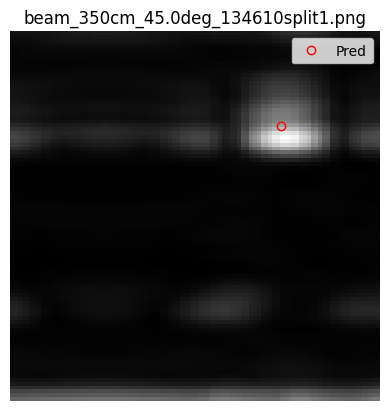

[beam_350cm_45.0deg_134610split2.png] Pred → dist: 350, angle: 45.0 | GT → dist: 350, angle: 45.0


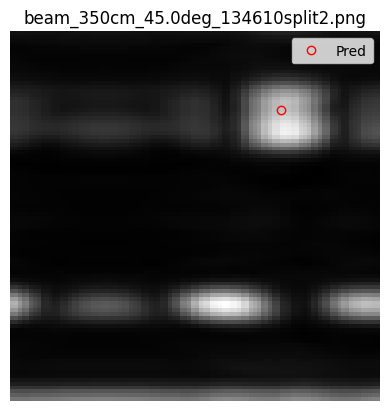

[beam_350cm_45.0deg_134610split3.png] Pred → dist: 150, angle: 22.5 | GT → dist: 350, angle: 45.0


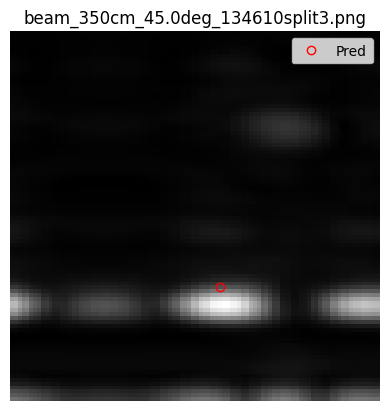

[beam_350cm_45.0deg_134610split4.png] Pred → dist: 350, angle: 45.0 | GT → dist: 350, angle: 45.0


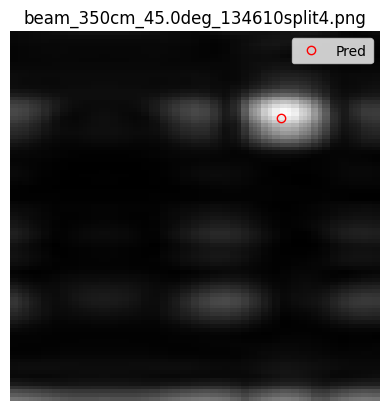

[beam_350cm_45.0deg_134610split5.png] Pred → dist: 350, angle: 45.0 | GT → dist: 350, angle: 45.0


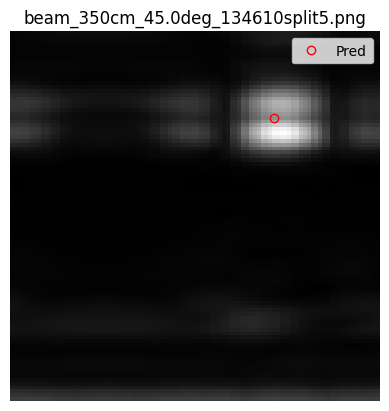

[beam_350cm_22.5deg_134350split1.png] Pred → dist: 350, angle: 22.5 | GT → dist: 350, angle: 22.5


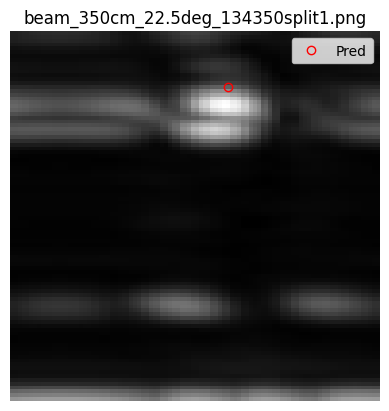

[beam_350cm_22.5deg_134350split2.png] Aucun centroid trouvé.


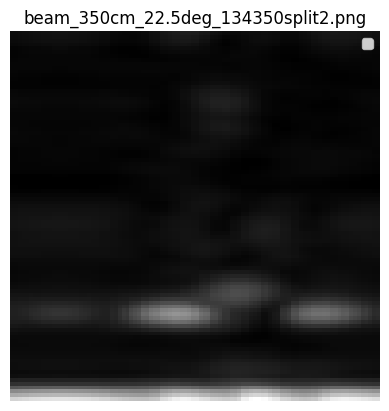

[beam_350cm_22.5deg_134350split3.png] Pred → dist: 350, angle: 45.0 | GT → dist: 350, angle: 22.5


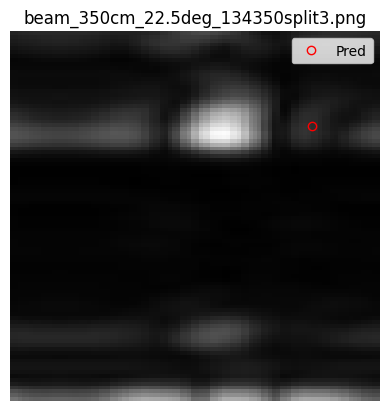

[beam_350cm_22.5deg_134350split4.png] Pred → dist: 350, angle: 22.5 | GT → dist: 350, angle: 22.5


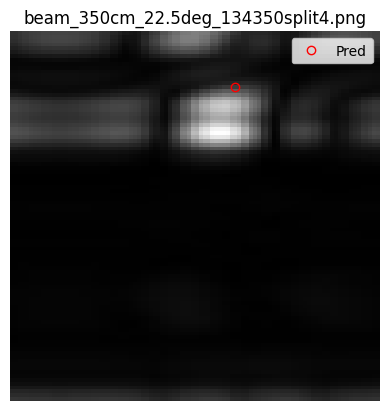

[beam_350cm_22.5deg_134350split5.png] Pred → dist: 350, angle: 22.5 | GT → dist: 350, angle: 22.5


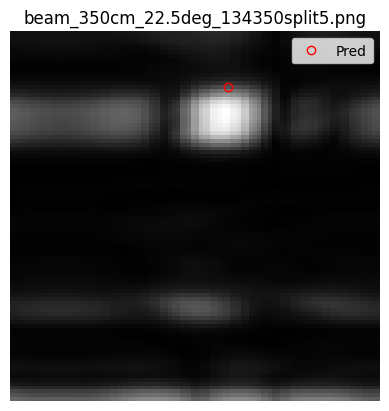

[beam_350cm_45.0deg_134905split1.png] Pred → dist: 350, angle: 45.0 | GT → dist: 350, angle: 45.0


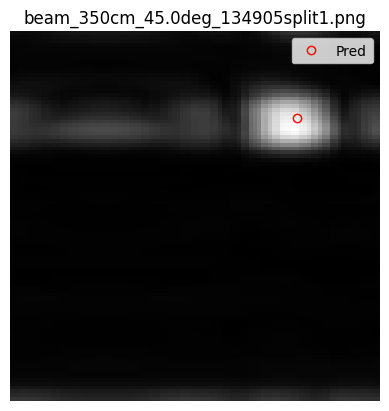

[beam_350cm_45.0deg_134905split2.png] Pred → dist: 350, angle: 45.0 | GT → dist: 350, angle: 45.0


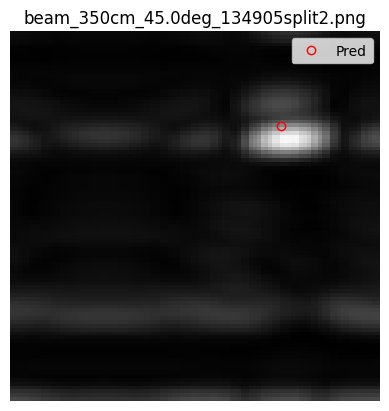

[beam_350cm_45.0deg_134905split3.png] Pred → dist: 350, angle: 67.5 | GT → dist: 350, angle: 45.0


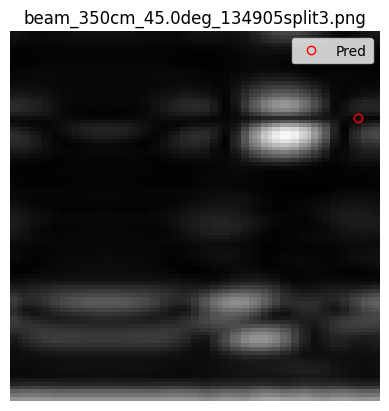

[beam_350cm_45.0deg_134905split4.png] Pred → dist: 350, angle: 45.0 | GT → dist: 350, angle: 45.0


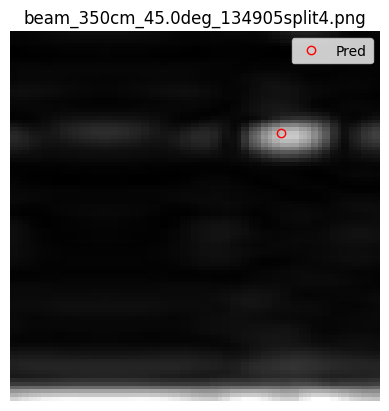

[beam_350cm_45.0deg_134905split5.png] Pred → dist: 350, angle: 45.0 | GT → dist: 350, angle: 45.0


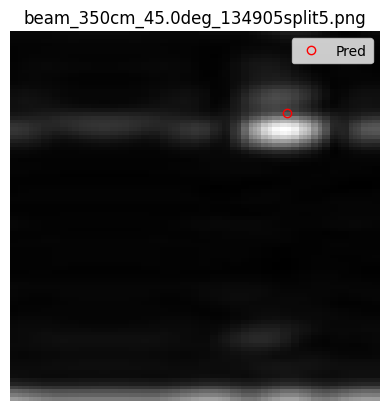

[beam_350cm_22.5deg_134107split1.png] Pred → dist: 350, angle: 22.5 | GT → dist: 350, angle: 22.5


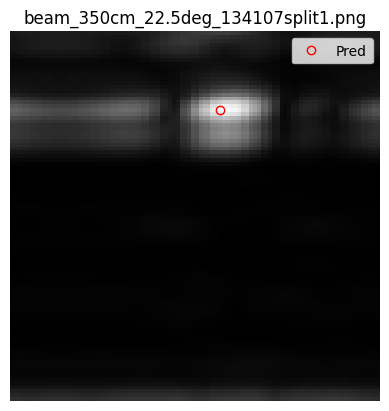

[beam_350cm_22.5deg_134107split2.png] Pred → dist: 350, angle: 22.5 | GT → dist: 350, angle: 22.5


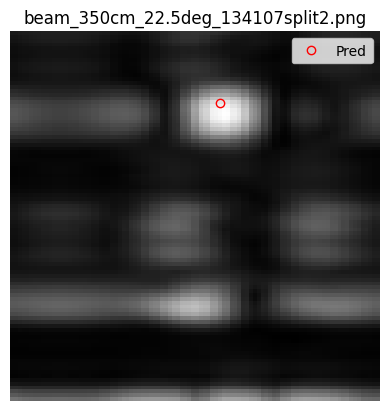

[beam_350cm_22.5deg_134107split3.png] Pred → dist: 350, angle: 22.5 | GT → dist: 350, angle: 22.5


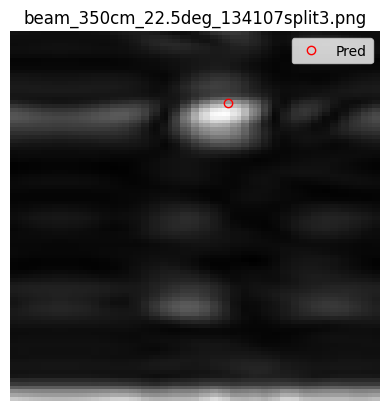

[beam_350cm_22.5deg_134107split4.png] Pred → dist: 350, angle: 22.5 | GT → dist: 350, angle: 22.5


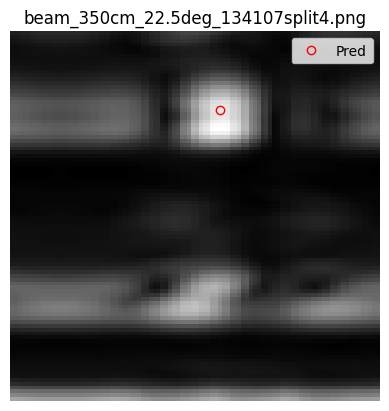

[beam_350cm_22.5deg_134107split5.png] Pred → dist: 150, angle: 22.5 | GT → dist: 350, angle: 22.5


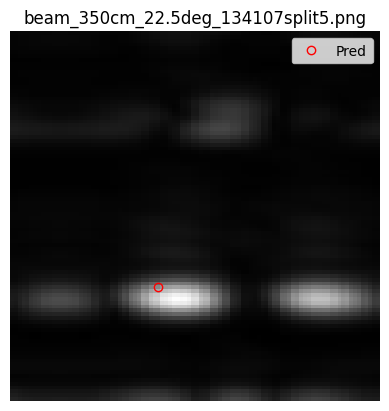

[beam_350cm_45.0deg_134501split1.png] Pred → dist: 150, angle: 67.5 | GT → dist: 350, angle: 45.0


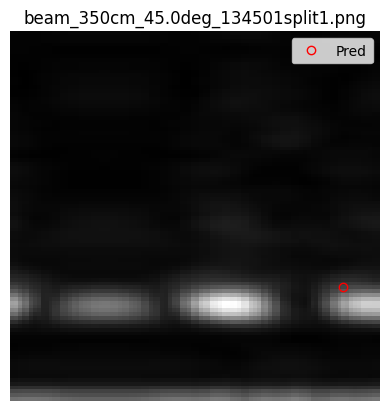

[beam_350cm_45.0deg_134501split2.png] Pred → dist: 350, angle: 45.0 | GT → dist: 350, angle: 45.0


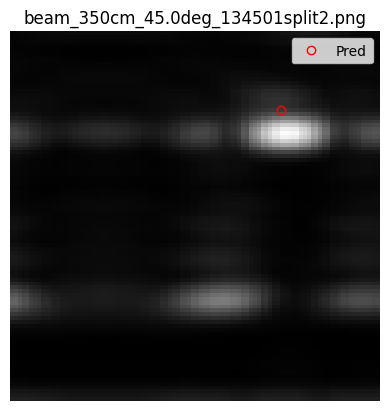

[beam_350cm_45.0deg_134501split3.png] Pred → dist: 150, angle: 22.5 | GT → dist: 350, angle: 45.0


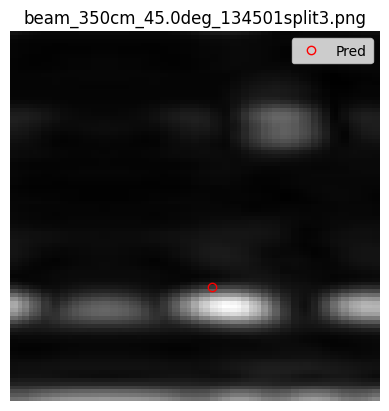

[beam_350cm_45.0deg_134501split4.png] Pred → dist: 350, angle: 45.0 | GT → dist: 350, angle: 45.0


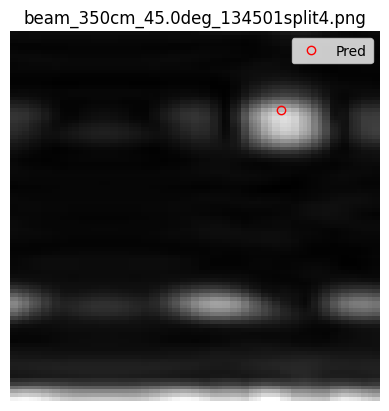

[beam_350cm_45.0deg_134501split5.png] Pred → dist: 350, angle: 45.0 | GT → dist: 350, angle: 45.0


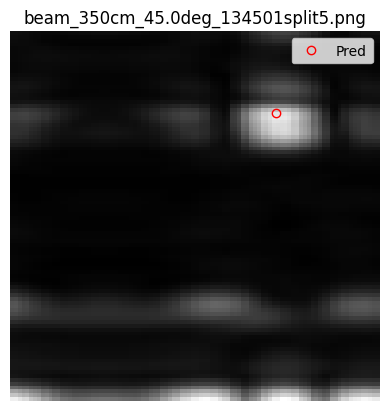

[beam_350cm_22.5deg_134221split1.png] Aucun centroid trouvé.


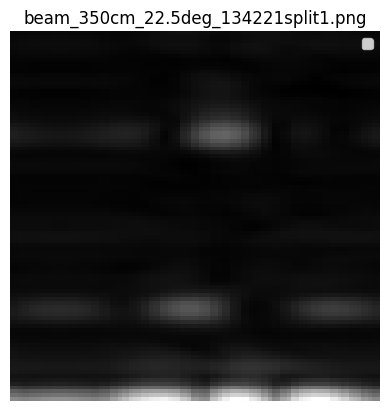

[beam_350cm_22.5deg_134221split2.png] Pred → dist: 350, angle: 45.0 | GT → dist: 350, angle: 22.5


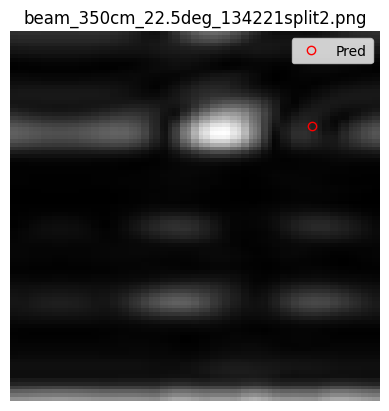

[beam_350cm_22.5deg_134221split3.png] Pred → dist: 350, angle: 22.5 | GT → dist: 350, angle: 22.5


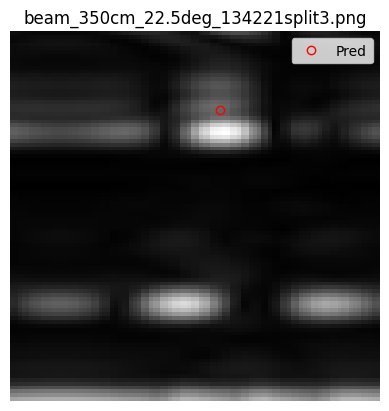

[beam_350cm_22.5deg_134221split4.png] Pred → dist: 150, angle: 22.5 | GT → dist: 350, angle: 22.5


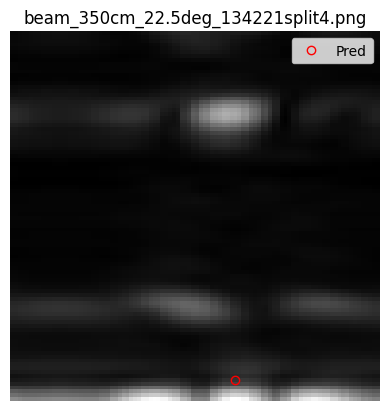

[beam_350cm_22.5deg_134221split5.png] Pred → dist: 350, angle: 22.5 | GT → dist: 350, angle: 22.5


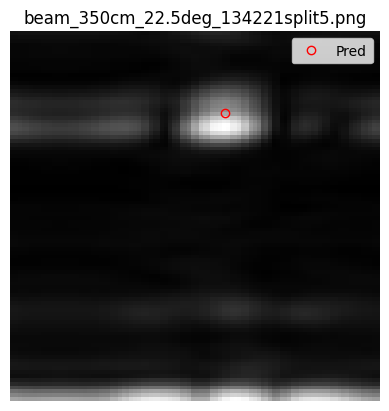

[beam_350cm_22.5deg_133958split1.png] Pred → dist: 350, angle: 22.5 | GT → dist: 350, angle: 22.5


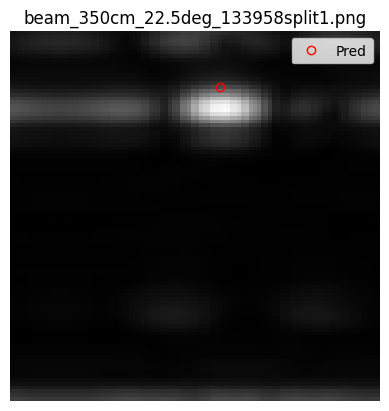

[beam_350cm_22.5deg_133958split2.png] Pred → dist: 350, angle: 22.5 | GT → dist: 350, angle: 22.5


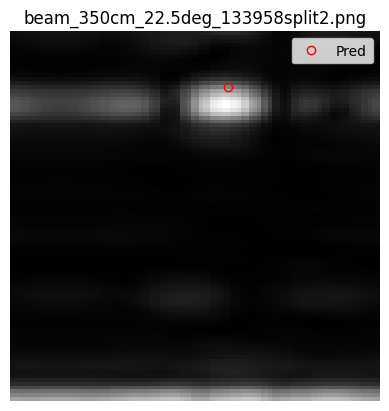

[beam_350cm_22.5deg_133958split3.png] Pred → dist: 350, angle: 22.5 | GT → dist: 350, angle: 22.5


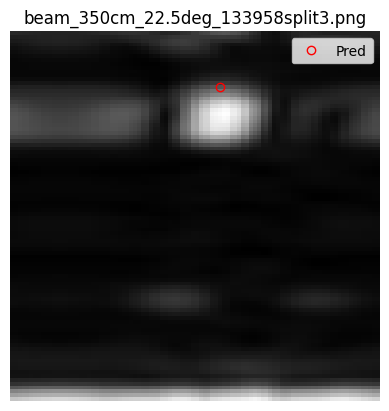

[beam_350cm_22.5deg_133958split4.png] Pred → dist: 350, angle: 22.5 | GT → dist: 350, angle: 22.5


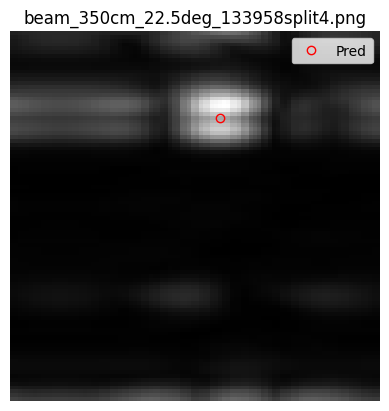

[beam_350cm_22.5deg_133958split5.png] Pred → dist: 350, angle: 22.5 | GT → dist: 350, angle: 22.5


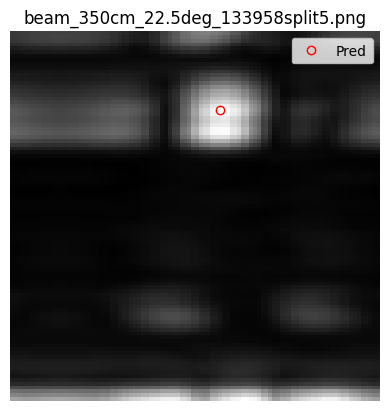

[beam_350cm_22.5deg_133849split1.png] Pred → dist: 150, angle: 22.5 | GT → dist: 350, angle: 22.5


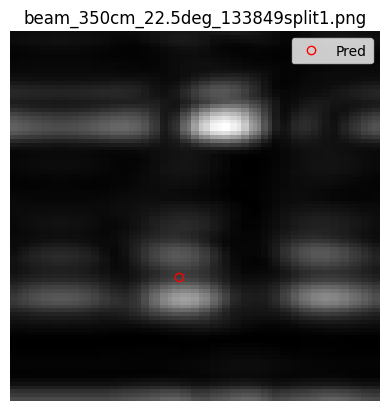

[beam_350cm_22.5deg_133849split2.png] Pred → dist: 150, angle: 67.5 | GT → dist: 350, angle: 22.5


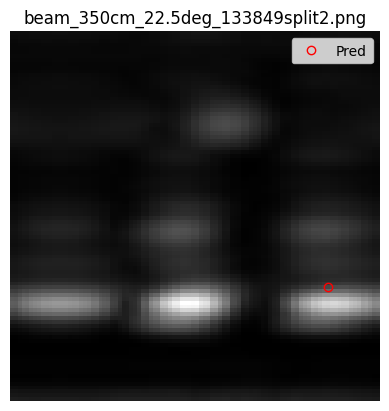

[beam_350cm_22.5deg_133849split3.png] Pred → dist: 350, angle: 45.0 | GT → dist: 350, angle: 22.5


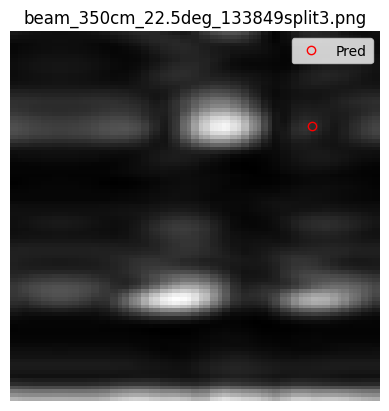

[beam_350cm_22.5deg_133849split4.png] Pred → dist: 150, angle: 22.5 | GT → dist: 350, angle: 22.5


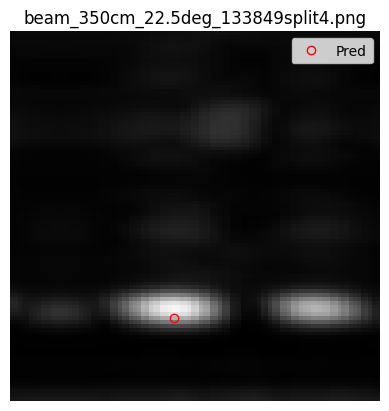

[beam_350cm_22.5deg_133849split5.png] Pred → dist: 150, angle: 22.5 | GT → dist: 350, angle: 22.5


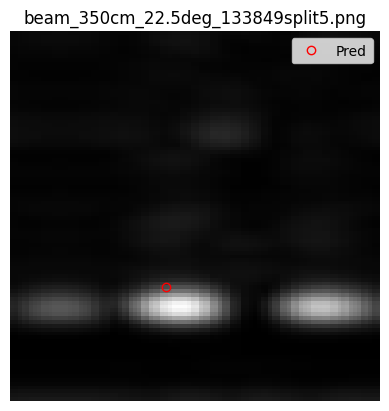

[beam_150cm_67.5deg_133537split1.png] Pred → dist: 150, angle: 67.5 | GT → dist: 150, angle: 67.5


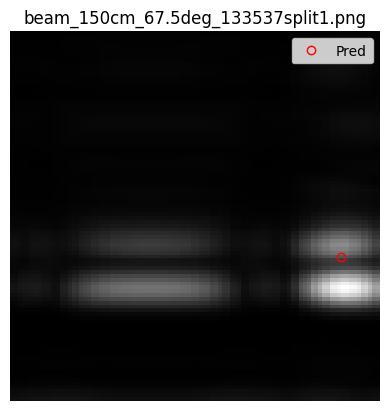

[beam_150cm_67.5deg_133537split2.png] Pred → dist: 250, angle: 67.5 | GT → dist: 150, angle: 67.5


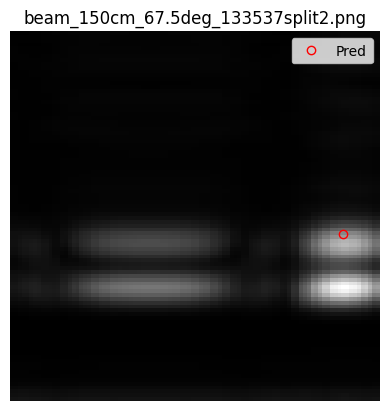

[beam_150cm_67.5deg_133537split3.png] Pred → dist: 150, angle: 67.5 | GT → dist: 150, angle: 67.5


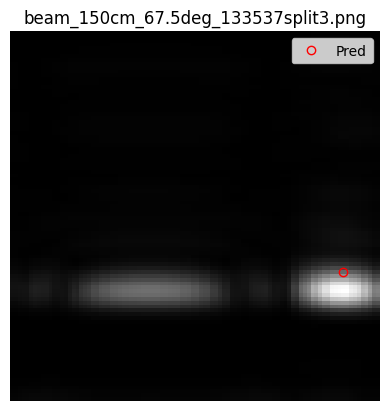

[beam_150cm_67.5deg_133537split4.png] Pred → dist: 150, angle: 67.5 | GT → dist: 150, angle: 67.5


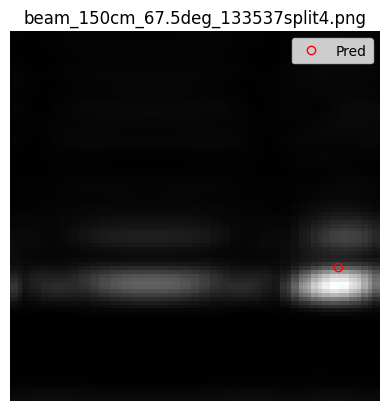

[beam_150cm_67.5deg_133537split5.png] Pred → dist: 150, angle: 67.5 | GT → dist: 150, angle: 67.5


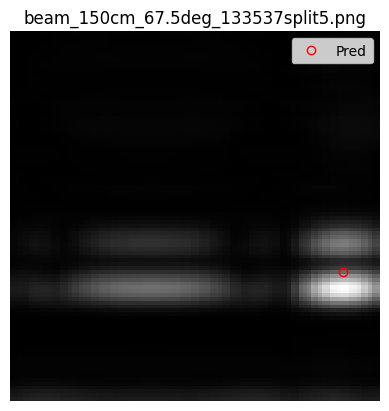

[beam_150cm_67.5deg_133644split1.png] Pred → dist: 150, angle: 67.5 | GT → dist: 150, angle: 67.5


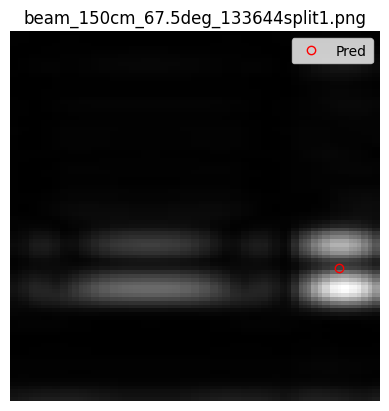

[beam_150cm_67.5deg_133644split2.png] Pred → dist: 150, angle: 67.5 | GT → dist: 150, angle: 67.5


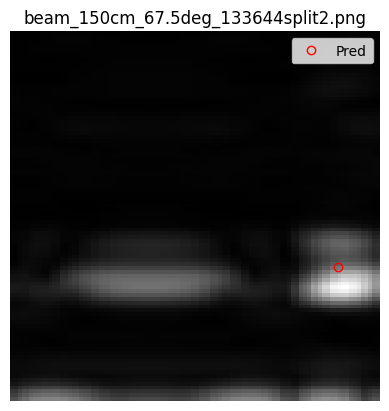

[beam_150cm_67.5deg_133644split3.png] Pred → dist: 150, angle: 67.5 | GT → dist: 150, angle: 67.5


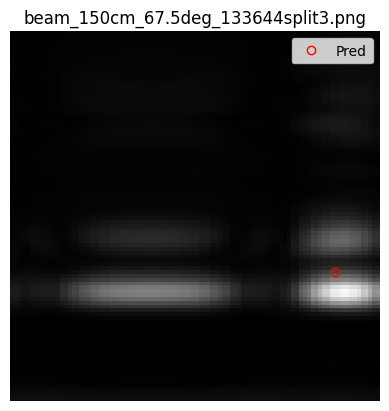

[beam_150cm_67.5deg_133644split4.png] Pred → dist: 150, angle: 67.5 | GT → dist: 150, angle: 67.5


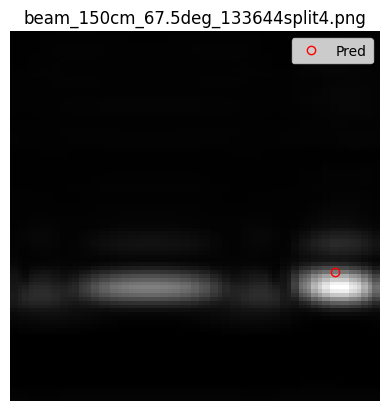

[beam_150cm_67.5deg_133644split5.png] Pred → dist: 150, angle: 67.5 | GT → dist: 150, angle: 67.5


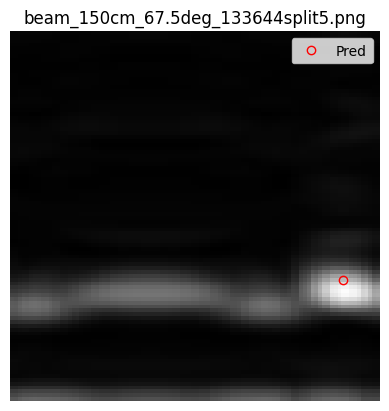

[beam_150cm_67.5deg_133429split1.png] Pred → dist: 150, angle: 67.5 | GT → dist: 150, angle: 67.5


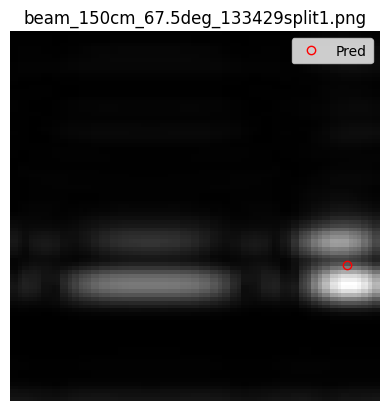

[beam_150cm_67.5deg_133429split2.png] Pred → dist: 150, angle: 67.5 | GT → dist: 150, angle: 67.5


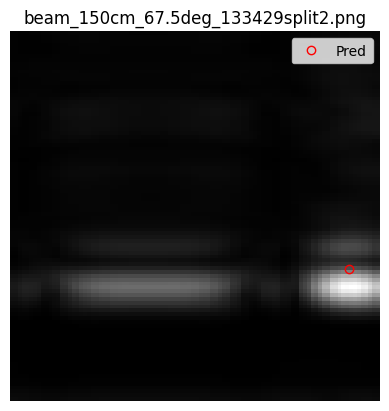

[beam_150cm_67.5deg_133429split3.png] Pred → dist: 150, angle: 67.5 | GT → dist: 150, angle: 67.5


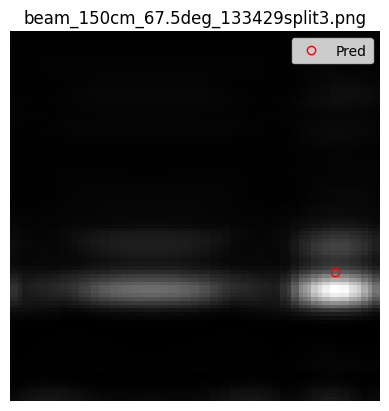

[beam_150cm_67.5deg_133429split4.png] Pred → dist: 150, angle: 67.5 | GT → dist: 150, angle: 67.5


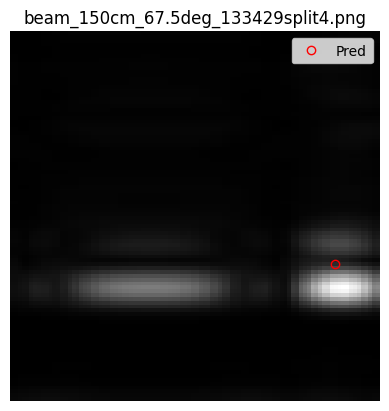

[beam_150cm_67.5deg_133429split5.png] Pred → dist: 150, angle: 67.5 | GT → dist: 150, angle: 67.5


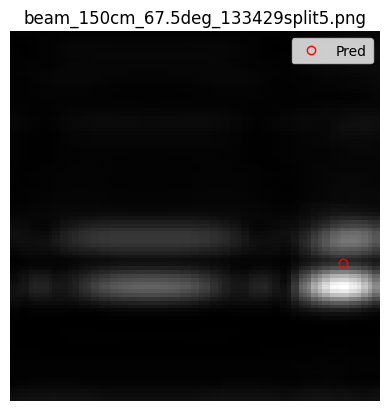

[beam_150cm_67.5deg_133322split1.png] Pred → dist: 150, angle: 67.5 | GT → dist: 150, angle: 67.5


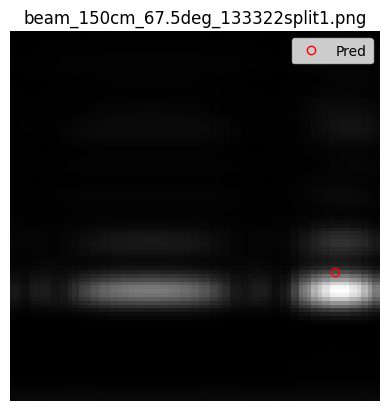

[beam_150cm_67.5deg_133322split2.png] Pred → dist: 150, angle: 67.5 | GT → dist: 150, angle: 67.5


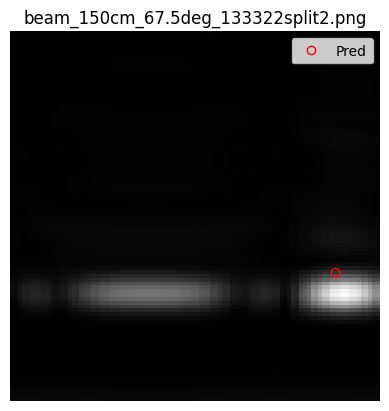

[beam_150cm_67.5deg_133322split3.png] Pred → dist: 150, angle: 67.5 | GT → dist: 150, angle: 67.5


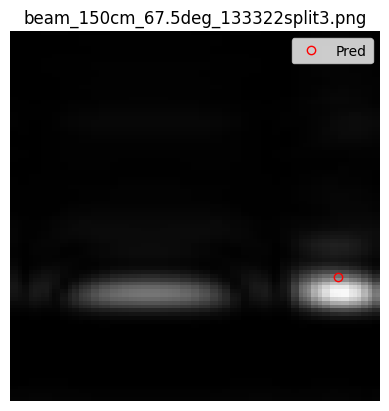

[beam_150cm_67.5deg_133322split4.png] Pred → dist: 150, angle: 67.5 | GT → dist: 150, angle: 67.5


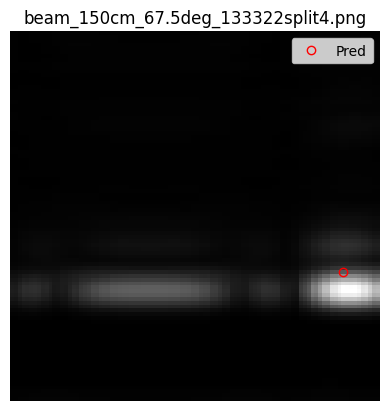

[beam_150cm_67.5deg_133322split5.png] Pred → dist: 150, angle: 67.5 | GT → dist: 150, angle: 67.5


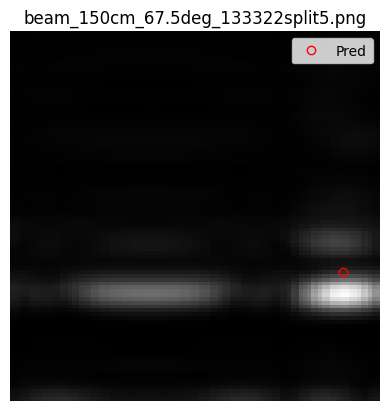

[beam_150cm_67.5deg_133214split1.png] Pred → dist: 150, angle: 67.5 | GT → dist: 150, angle: 67.5


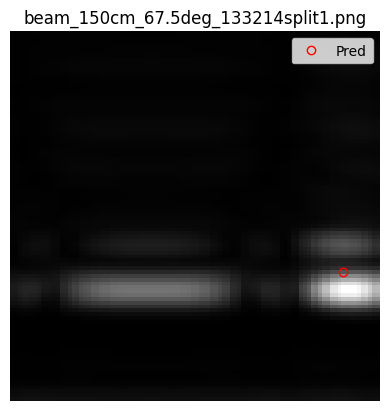

[beam_150cm_67.5deg_133214split2.png] Pred → dist: 150, angle: 67.5 | GT → dist: 150, angle: 67.5


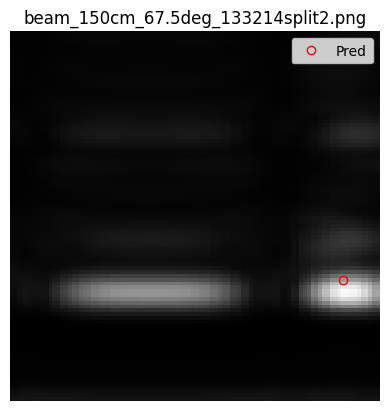

[beam_150cm_67.5deg_133214split3.png] Pred → dist: 150, angle: 67.5 | GT → dist: 150, angle: 67.5


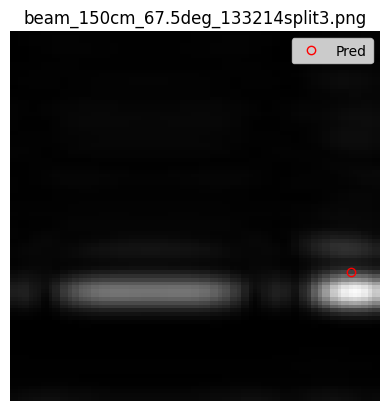

[beam_150cm_67.5deg_133214split4.png] Pred → dist: 150, angle: 67.5 | GT → dist: 150, angle: 67.5


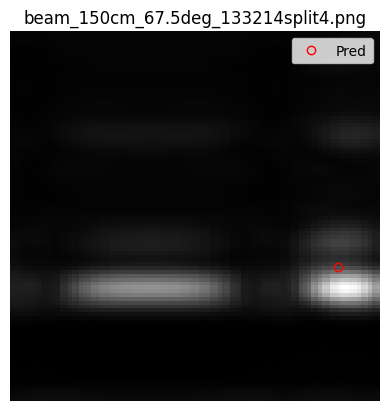

[beam_150cm_67.5deg_133214split5.png] Pred → dist: 150, angle: 67.5 | GT → dist: 150, angle: 67.5


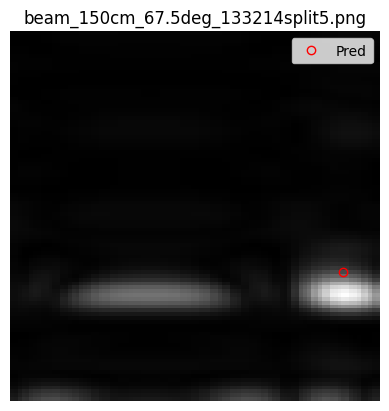

[beam_150cm_45.0deg_132927split1.png] Pred → dist: 250, angle: 45.0 | GT → dist: 150, angle: 45.0


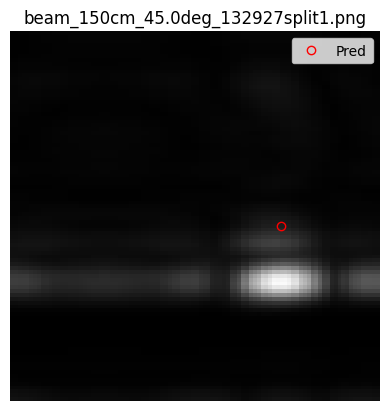

[beam_150cm_45.0deg_132927split2.png] Pred → dist: 150, angle: 45.0 | GT → dist: 150, angle: 45.0


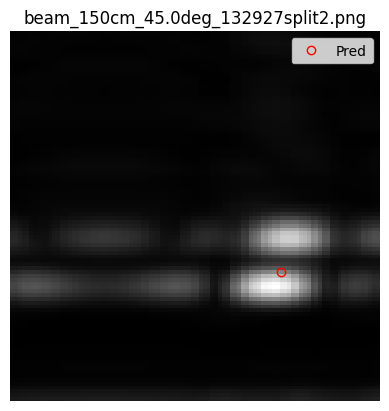

[beam_150cm_45.0deg_132927split3.png] Pred → dist: 150, angle: 45.0 | GT → dist: 150, angle: 45.0


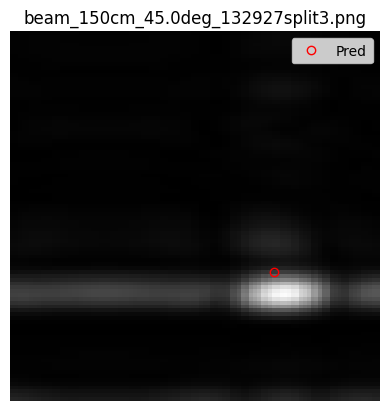

[beam_150cm_45.0deg_132927split4.png] Pred → dist: 150, angle: 45.0 | GT → dist: 150, angle: 45.0


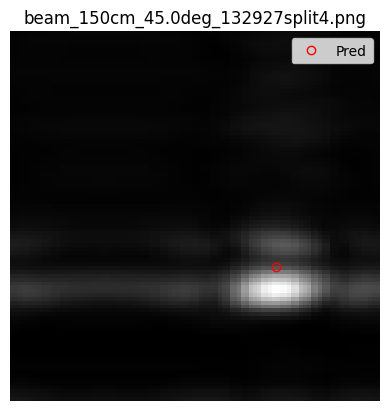

[beam_150cm_45.0deg_132927split5.png] Pred → dist: 150, angle: 45.0 | GT → dist: 150, angle: 45.0


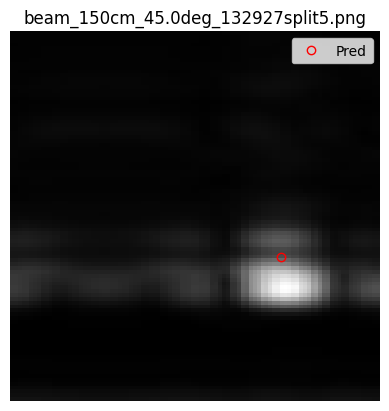

[beam_150cm_45.0deg_132558split1.png] Pred → dist: 150, angle: 45.0 | GT → dist: 150, angle: 45.0


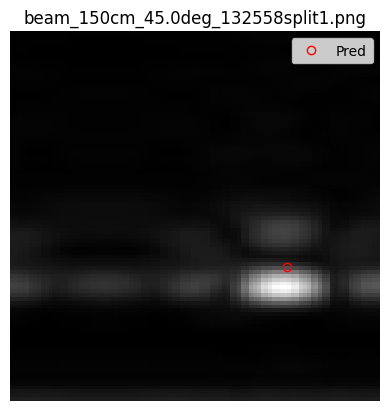

[beam_150cm_45.0deg_132558split2.png] Pred → dist: 250, angle: 22.5 | GT → dist: 150, angle: 45.0


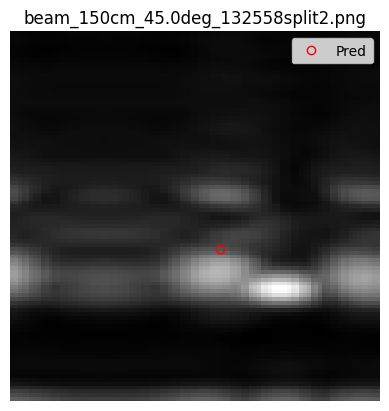

[beam_150cm_45.0deg_132558split3.png] Pred → dist: 150, angle: 22.5 | GT → dist: 150, angle: 45.0


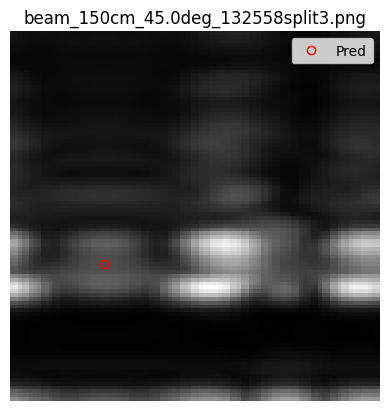

[beam_150cm_45.0deg_132558split4.png] Pred → dist: 150, angle: 22.5 | GT → dist: 150, angle: 45.0


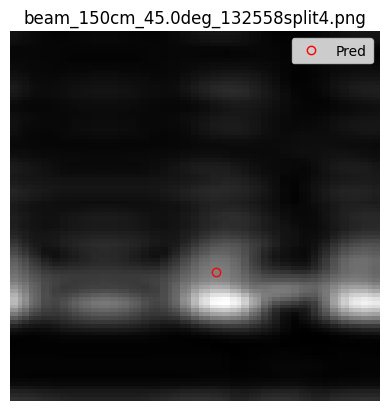

[beam_150cm_45.0deg_132558split5.png] Pred → dist: 250, angle: 45.0 | GT → dist: 150, angle: 45.0


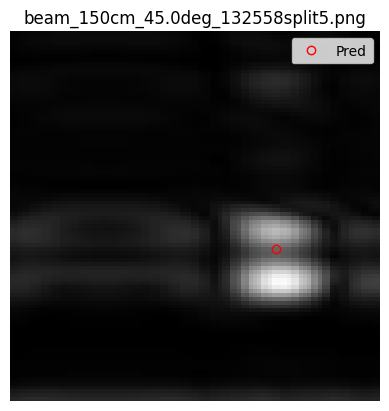

[beam_150cm_45.0deg_132706split1.png] Pred → dist: 150, angle: 45.0 | GT → dist: 150, angle: 45.0


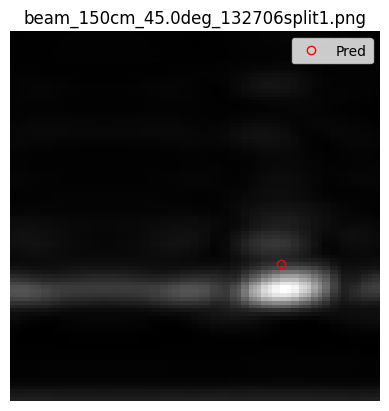

[beam_150cm_45.0deg_132706split2.png] Pred → dist: 150, angle: 45.0 | GT → dist: 150, angle: 45.0


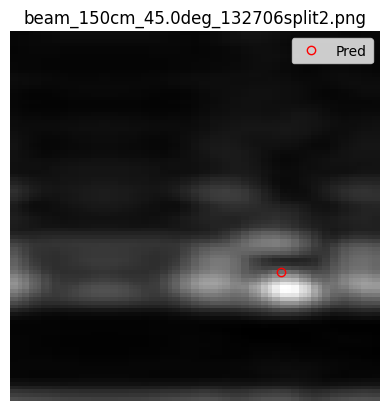

[beam_150cm_45.0deg_132706split3.png] Pred → dist: 150, angle: 45.0 | GT → dist: 150, angle: 45.0


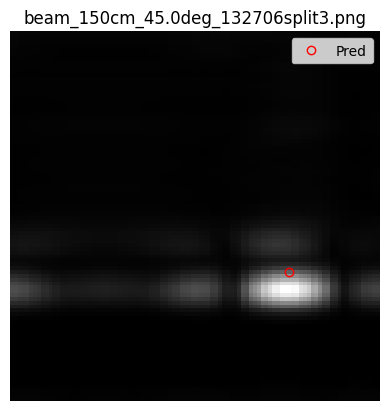

[beam_150cm_45.0deg_132706split4.png] Pred → dist: 150, angle: 45.0 | GT → dist: 150, angle: 45.0


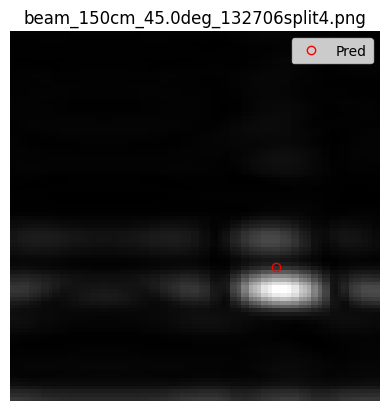

[beam_150cm_45.0deg_132706split5.png] Pred → dist: 150, angle: 45.0 | GT → dist: 150, angle: 45.0


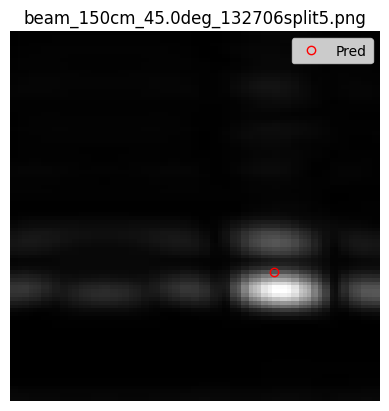

[beam_150cm_45.0deg_133033split1.png] Pred → dist: 150, angle: 45.0 | GT → dist: 150, angle: 45.0


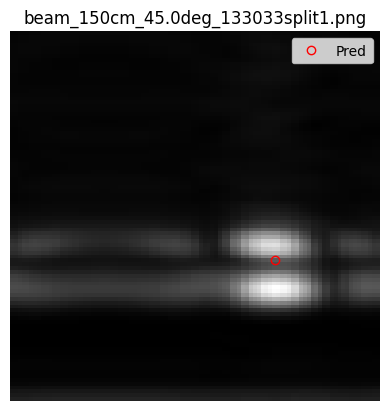

[beam_150cm_45.0deg_133033split2.png] Pred → dist: 150, angle: 45.0 | GT → dist: 150, angle: 45.0


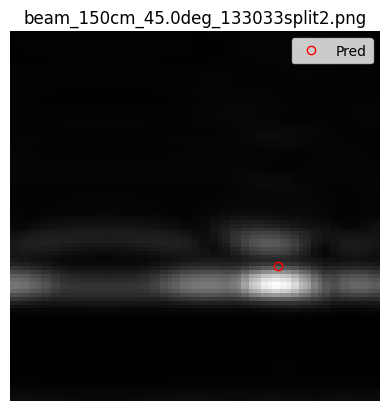

[beam_150cm_45.0deg_133033split3.png] Pred → dist: 150, angle: 45.0 | GT → dist: 150, angle: 45.0


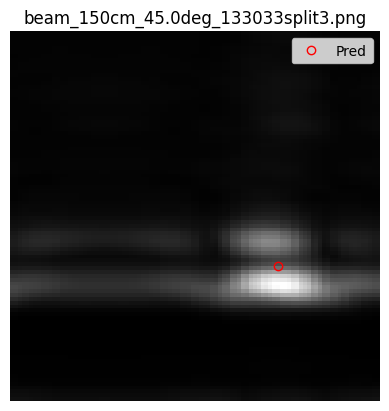

[beam_150cm_45.0deg_133033split4.png] Pred → dist: 150, angle: 45.0 | GT → dist: 150, angle: 45.0


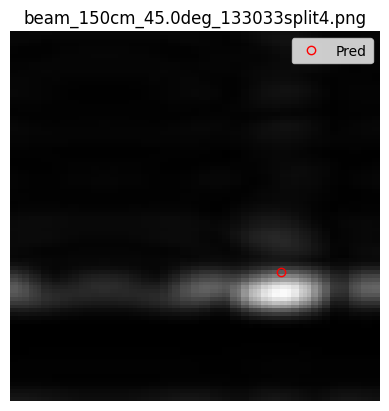

[beam_150cm_45.0deg_133033split5.png] Pred → dist: 250, angle: 45.0 | GT → dist: 150, angle: 45.0


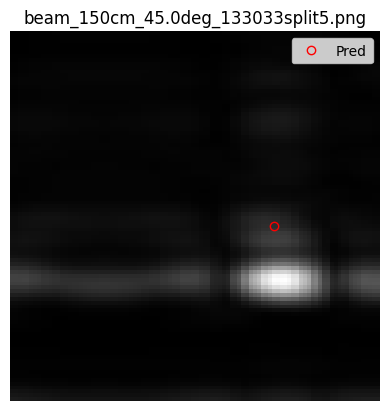

[beam_150cm_45.0deg_132819split1.png] Pred → dist: 150, angle: 45.0 | GT → dist: 150, angle: 45.0


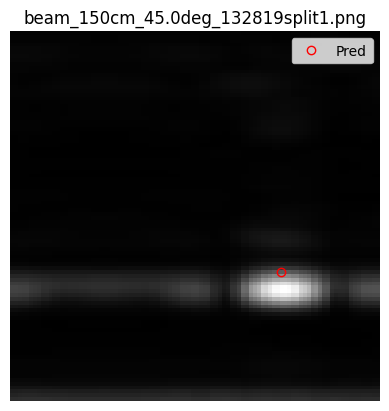

[beam_150cm_45.0deg_132819split2.png] Pred → dist: 150, angle: 45.0 | GT → dist: 150, angle: 45.0


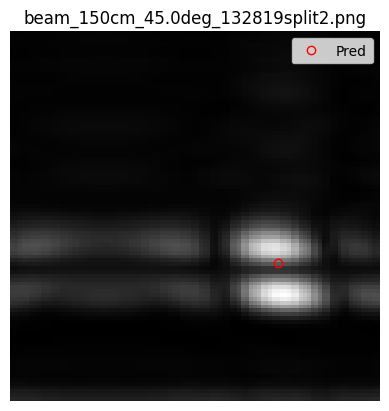

[beam_150cm_45.0deg_132819split3.png] Pred → dist: 150, angle: 45.0 | GT → dist: 150, angle: 45.0


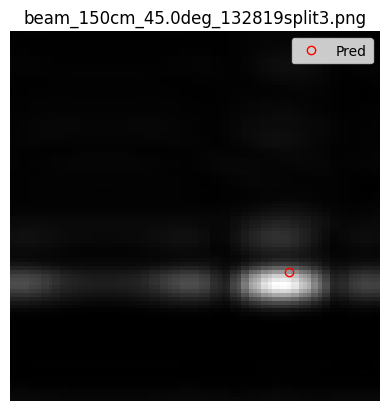

[beam_150cm_45.0deg_132819split4.png] Pred → dist: 150, angle: 45.0 | GT → dist: 150, angle: 45.0


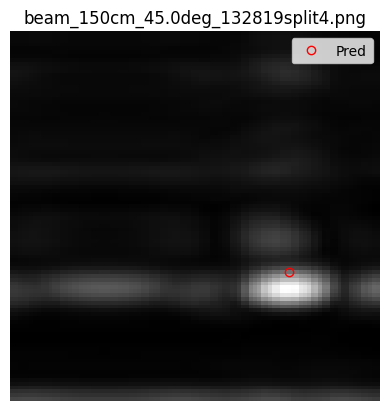

[beam_150cm_45.0deg_132819split5.png] Pred → dist: 150, angle: 45.0 | GT → dist: 150, angle: 45.0


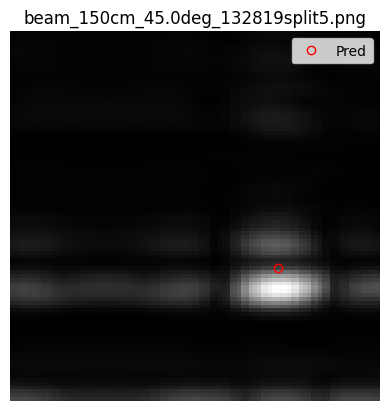

[beam_150cm_22.5deg_131826split1.png] Pred → dist: 150, angle: 22.5 | GT → dist: 150, angle: 22.5


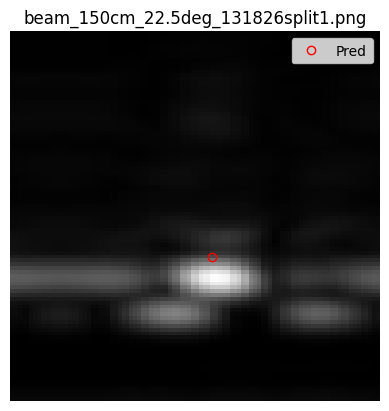

[beam_150cm_22.5deg_131826split2.png] Aucun centroid trouvé.


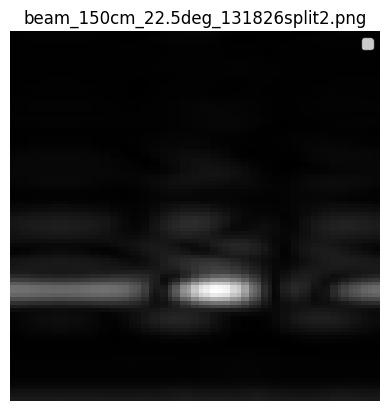

[beam_150cm_22.5deg_131826split3.png] Pred → dist: 250, angle: 22.5 | GT → dist: 150, angle: 22.5


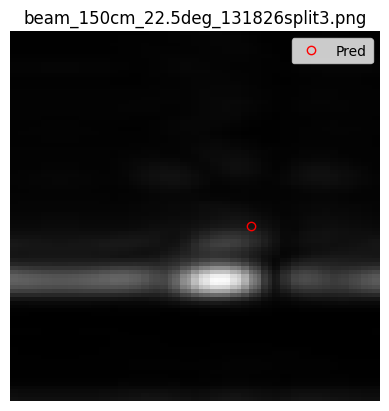

[beam_150cm_22.5deg_131826split4.png] Pred → dist: 150, angle: 22.5 | GT → dist: 150, angle: 22.5


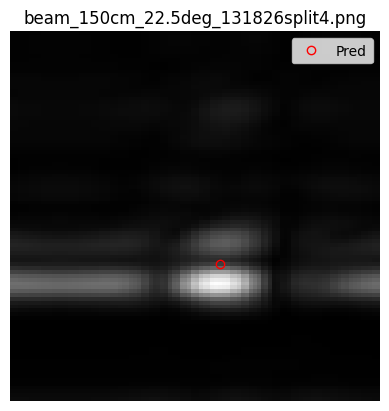

[beam_150cm_22.5deg_131826split5.png] Pred → dist: 150, angle: 22.5 | GT → dist: 150, angle: 22.5


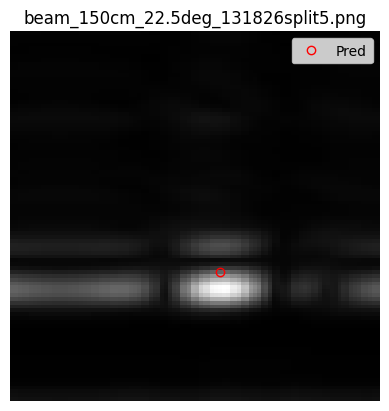

[beam_150cm_22.5deg_131934split1.png] Pred → dist: 250, angle: 22.5 | GT → dist: 150, angle: 22.5


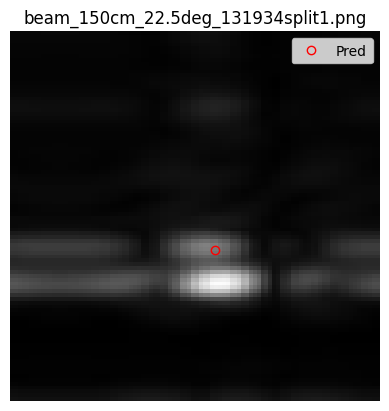

[beam_150cm_22.5deg_131934split2.png] Pred → dist: 150, angle: 22.5 | GT → dist: 150, angle: 22.5


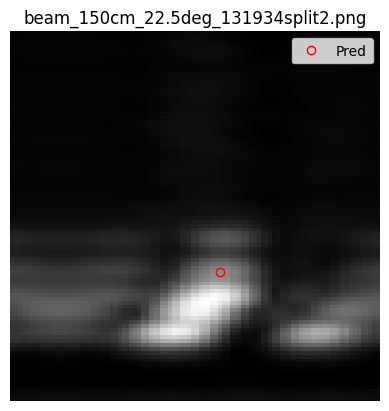

[beam_150cm_22.5deg_131934split3.png] Pred → dist: 150, angle: 22.5 | GT → dist: 150, angle: 22.5


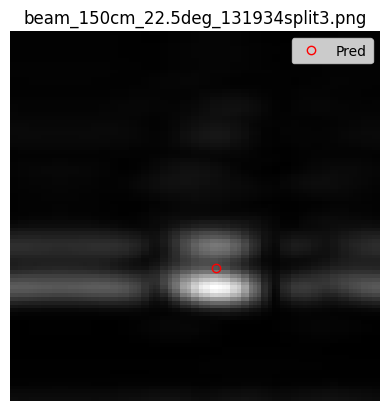

[beam_150cm_22.5deg_131934split4.png] Pred → dist: 150, angle: 22.5 | GT → dist: 150, angle: 22.5


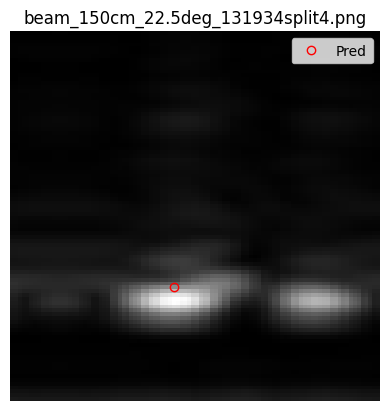

[beam_150cm_22.5deg_131934split5.png] Pred → dist: 150, angle: 22.5 | GT → dist: 150, angle: 22.5


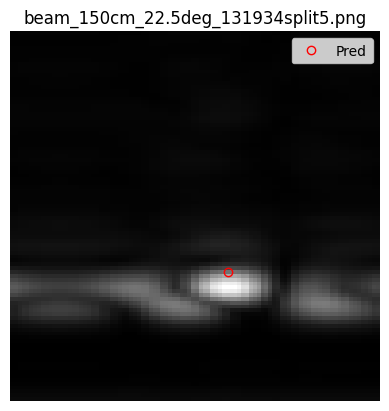

[beam_150cm_22.5deg_132105split1.png] Pred → dist: 250, angle: 22.5 | GT → dist: 150, angle: 22.5


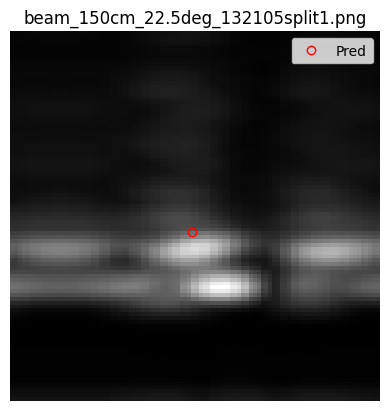

[beam_150cm_22.5deg_132105split2.png] Pred → dist: 150, angle: 22.5 | GT → dist: 150, angle: 22.5


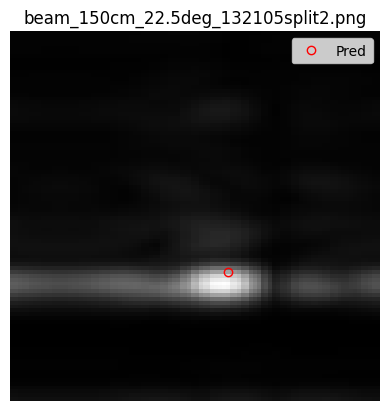

[beam_150cm_22.5deg_132105split3.png] Pred → dist: 150, angle: 22.5 | GT → dist: 150, angle: 22.5


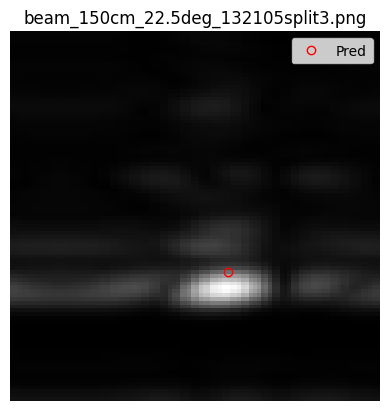

[beam_150cm_22.5deg_132105split4.png] Pred → dist: 150, angle: 22.5 | GT → dist: 150, angle: 22.5


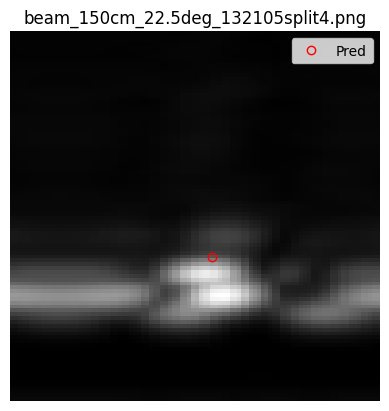

[beam_150cm_22.5deg_132105split5.png] Pred → dist: 150, angle: 22.5 | GT → dist: 150, angle: 22.5


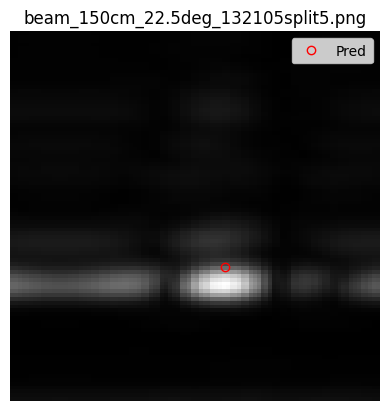

[beam_150cm_22.5deg_132333split1.png] Pred → dist: 150, angle: 22.5 | GT → dist: 150, angle: 22.5


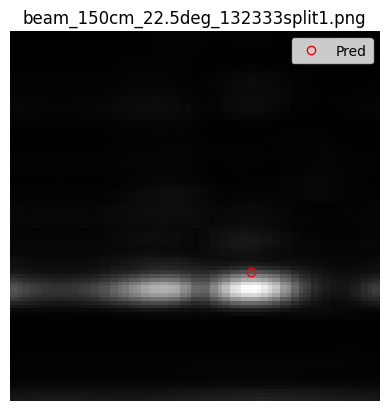

[beam_150cm_22.5deg_132333split2.png] Pred → dist: 150, angle: 22.5 | GT → dist: 150, angle: 22.5


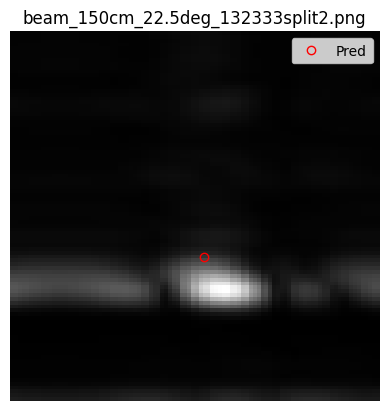

[beam_150cm_22.5deg_132333split3.png] Pred → dist: 150, angle: 22.5 | GT → dist: 150, angle: 22.5


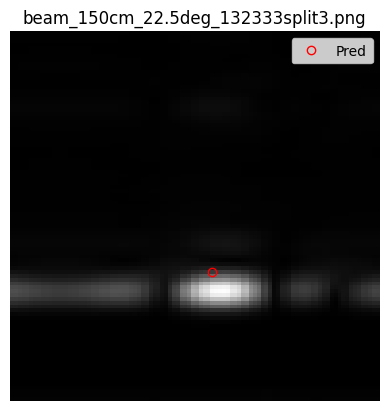

[beam_150cm_22.5deg_132333split4.png] Pred → dist: 150, angle: 22.5 | GT → dist: 150, angle: 22.5


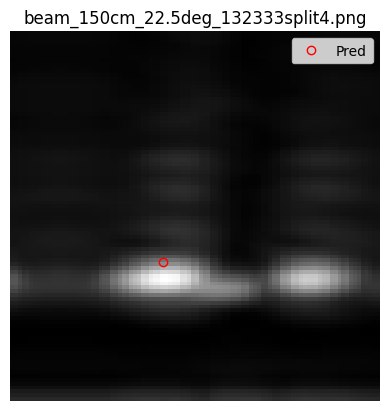

[beam_150cm_22.5deg_132333split5.png] Pred → dist: 150, angle: 22.5 | GT → dist: 150, angle: 22.5


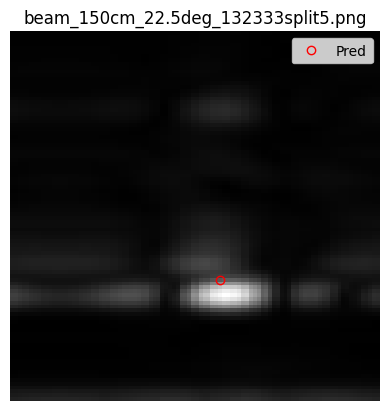

[beam_150cm_22.5deg_131716split1.png] Pred → dist: 150, angle: 22.5 | GT → dist: 150, angle: 22.5


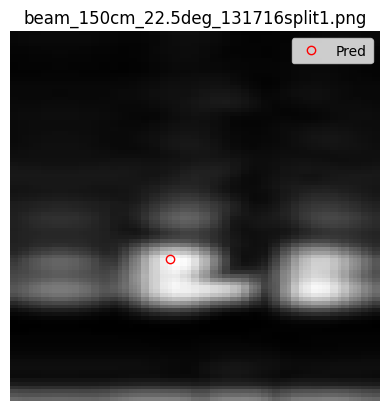

[beam_150cm_22.5deg_131716split2.png] Pred → dist: 150, angle: 22.5 | GT → dist: 150, angle: 22.5


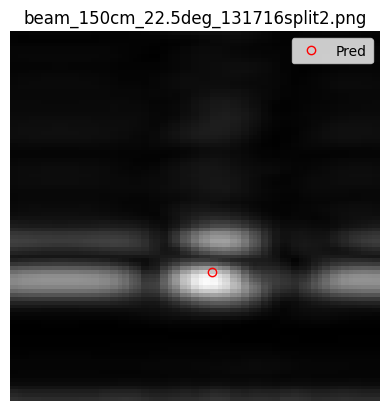

[beam_150cm_22.5deg_131716split3.png] Pred → dist: 150, angle: 22.5 | GT → dist: 150, angle: 22.5


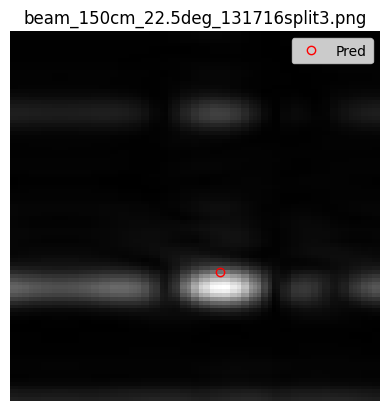

[beam_150cm_22.5deg_131716split4.png] Pred → dist: 150, angle: 22.5 | GT → dist: 150, angle: 22.5


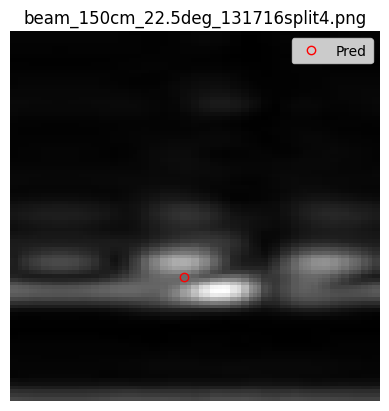

[beam_150cm_22.5deg_131716split5.png] Pred → dist: 150, angle: 22.5 | GT → dist: 150, angle: 22.5


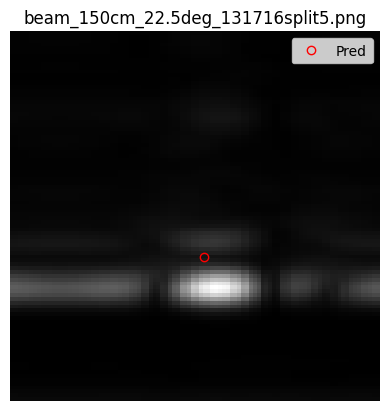

[beam_150cm_22.5deg_131559split1.png] Pred → dist: 250, angle: 22.5 | GT → dist: 150, angle: 22.5


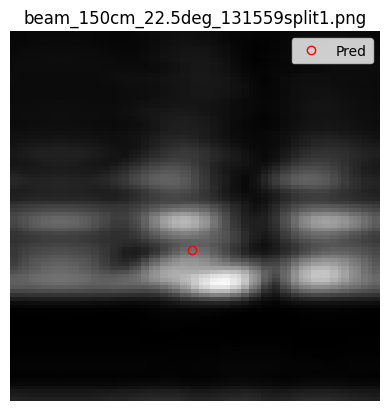

[beam_150cm_22.5deg_131559split2.png] Pred → dist: 150, angle: 22.5 | GT → dist: 150, angle: 22.5


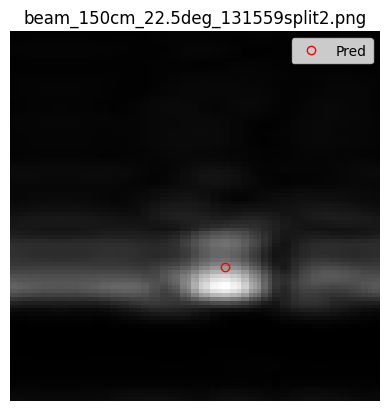

[beam_150cm_22.5deg_131559split3.png] Pred → dist: 150, angle: 22.5 | GT → dist: 150, angle: 22.5


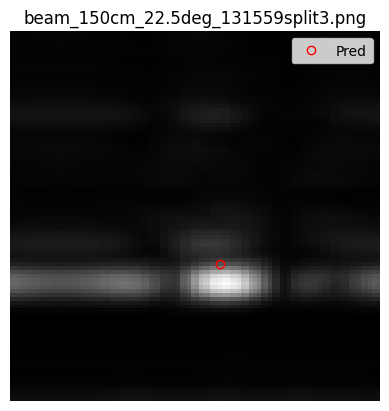

[beam_150cm_22.5deg_131559split4.png] Pred → dist: 150, angle: 22.5 | GT → dist: 150, angle: 22.5


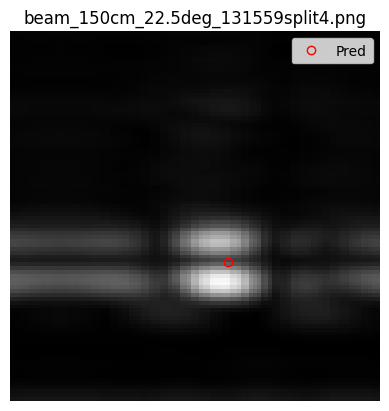

[beam_150cm_22.5deg_131559split5.png] Pred → dist: 150, angle: 22.5 | GT → dist: 150, angle: 22.5


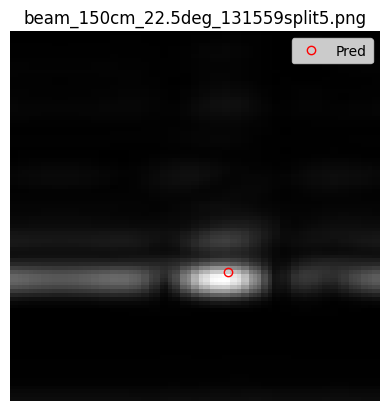


==== Résultats ====
Total fichiers valides : 235
Prédictions correctes (distance + angle) : 178
Accuracy classification (2D): 0.76


In [11]:
correct_both = 0
total_valid = 0
ram_usage_list = []
tflite_size = os.path.getsize("fomo96p01.tflite") / 1024  # en KB
print(f"TFLite model size: {tflite_size:.2f} KB")
interpreter = tf.lite.Interpreter(model_path="fomo96p01.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_height, input_width = input_details[0]['shape'][1:3] if input_details[0]['shape'][1] != 3 else input_details[0]['shape'][2:4]
input_is_nchw = input_details[0]['shape'][1] == 3

# === Inference Loop ===
from google.colab import drive
drive.mount('/content/drive')
image_dir = "/content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3"
image_files = [f for f in os.listdir(image_dir) if f.endswith((".png", ".jpg"))]



input_is_nchw = 1
for filename in image_files:
    img_path = os.path.join(image_dir, filename)
    polar = extract_polar_from_filename(filename)
    if polar is None:
        print(f" Filename skipped (invalid format): {filename}")
        continue
    true_dist_class, true_angle_class = assign_to_nearest(polar[0], valid_distances), assign_to_nearest(polar[1], valid_angles)

    img = Image.open(img_path).convert('RGB')
    img_resized = img.resize((96, 96))
    img_np = np.array(img_resized).astype(np.float32) / 255.0
    if input_is_nchw:
        input_tensor = np.transpose(img_np, (2, 0, 1))[np.newaxis, ...]
    else:
        input_tensor = img_np[np.newaxis, ...]

    interpreter.set_tensor(input_details[0]['index'], input_tensor)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])[0, 0]


    preds_bin = output_data > 0.5
    centroid = get_largest_blob_centroid(preds_bin, (96, 96), output_data.shape)

    if centroid is not None:
        cx_p, cy_p = centroid
        pred_dist_cm, pred_angle_deg = pixel_to_polar(cx_p, cy_p, (96, 96))
        pred_dist_class = assign_to_nearest(pred_dist_cm, valid_distances)
        pred_angle_class = assign_to_nearest(pred_angle_deg, valid_angles)

        print(f"[{filename}] Pred → dist: {pred_dist_class}, angle: {pred_angle_class} | GT → dist: {true_dist_class}, angle: {true_angle_class}")

        if pred_dist_class == true_dist_class and pred_angle_class == true_angle_class:
            correct_both += 1
        total_valid += 1
    else:
        print(f"[{filename}] Aucun centroid trouvé.")
        total_valid += 1  # on peut ignorer ici ou non selon critère

    fig, ax = plt.subplots()
    ax.imshow(np.array(img_resized))
    if centroid is not None:
        ax.plot(cx_p, cy_p, 'ro', markerfacecolor='none', label='Pred')
    ax.set_title(filename)
    ax.legend(loc='upper right')
    ax.axis('off')
    plt.show()

accuracy = correct_both / total_valid if total_valid > 0 else 0

print("\n==== Résultats ====")
print(f"Total fichiers valides : {total_valid}")
print(f"Prédictions correctes (distance + angle) : {correct_both}")
print(f"Accuracy classification (2D): {accuracy:.2f}")
